In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import Dict, Tuple, Iterable, Union, Dict, Any

import seaborn as sns

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import xgboost as xgb
import folium

%matplotlib inline

---
# DATA

In [72]:
TRIPS_CSV = "Trips_2018.csv"
TRIPS_CSV_PROXY = "Trips_2018_short.csv"
PROXY_USAGE = False

#df = pd.read_csv("Trips_2018.csv")
#short_df = df.head(1000)
#short_df.to_csv("Trips_2018_short.csv", index=False)


df_path = TRIPS_CSV_PROXY if PROXY_USAGE else TRIPS_CSV
df = pd.read_csv(df_path)
df.drop('Unnamed: 0', axis=1, inplace=True)

print(df.shape)
df.head()

(17548339, 13)


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


---
# PREPROCESS - TASK 1

## STATIONS - TASK 1

In [73]:
#COLLECT STATIONS
print("Unique starting st ids:", len(df['start_station_id'].unique()))
print("Unique ending st ids:", len(df['end_station_id'].unique()))

print("Unique starting st coords:", len(df[["start_station_latitude", "start_station_longitude"]].drop_duplicates()))
print("Unique ending st coords:", len(df[["end_station_latitude", "end_station_longitude"]].drop_duplicates()))

Unique starting st ids: 819
Unique ending st ids: 851
Unique starting st coords: 919
Unique ending st coords: 954


In [74]:

def collect_stations(df) -> pd.DataFrame:
    # Collect unique stations by coordinates (not by station id) and assign new IDs.
    # Uses existing `df` DataFrame.

    # extract unique start and end coordinates and unify them
    start_coords = df[['start_station_latitude', 'start_station_longitude']].dropna()
    start_coords.columns = ['latitude', 'longitude']
    end_coords = df[['end_station_latitude', 'end_station_longitude']].dropna()
    end_coords.columns = ['latitude', 'longitude']

    stations = pd.concat([start_coords, end_coords], ignore_index=True).drop_duplicates().reset_index(drop=True)

    # assign new station ids
    stations['station_uid'] = range(0, len(stations))  
    stations = stations[['station_uid', 'latitude', 'longitude']]

    print("Number of unique stations (by coordinates):", len(stations))
    print(stations.head())
    return stations

stations = collect_stations(df)

Number of unique stations (by coordinates): 957
   station_uid   latitude  longitude
0            0  40.767272 -73.993929
1            1  40.719116 -74.006667
2            2  40.711174 -74.000165
3            3  40.683826 -73.976323
4            4  40.696089 -73.978034


---
### CLUSTERING - TASK 1

In [75]:

def evaluate_station_clustering(
    stations: pd.DataFrame,
    feature_cols: Iterable[str] = ("latitude", "longitude"),
    cluster_col: str = "cluster",
    drop_noise: bool = True,
    noise_labels: Union[int, str, Iterable] = (-1, "-1"),
    treat_na_as_noise: bool = True
):
    """
    Evaluate clustering quality for station coordinates (distortion & silhouette),
    and report how many noise points were collected.

    Compatible with your DBSCAN & KMeans outputs:
      - DBSCAN: noise usually -1 (if kept)
      - KMeans: small clusters may be set to -1 or NaN depending on mark_noise
    """
    df = stations.copy()

    # Build noise mask

    labels_ser = df[cluster_col]
    mask_noise = labels_ser.isin(noise_labels)
    if treat_na_as_noise:
        mask_noise |= labels_ser.isna()

    n_noise = int(mask_noise.sum())
    n_total = int(len(df))

    # Optionally drop noise from evaluation set
    if drop_noise:
        df = df.loc[~mask_noise].copy()

   
    X = df.loc[:, feature_cols].to_numpy()
    labels = df[cluster_col].to_numpy()

    # Filter any lingering NaNs (shouldn't happen if treat_na_as_noise=True & drop_noise=True)
    valid = ~pd.isna(labels)
    X = X[valid]
    labels = labels[valid]

    unique = np.unique(labels)

    # Distortion (SSE) via centroids
    sse_total = 0.0
    for c in unique:
        Xi = X[labels == c]
        ctr = Xi.mean(axis=0)
        sse_c = float(((Xi - ctr) ** 2).sum())
        sse_total += sse_c

    sil = float(silhouette_score(X, labels, metric="euclidean"))

    return {
        "n_points": int(X.shape[0]),                 # evaluated (after dropping noise if drop_noise=True)
        "n_points_total": n_total,                   # total before dropping
        "n_noise": n_noise,                          # number of noise points collected
        "n_clusters": int(len(unique)),
        "distortion_sse": float(sse_total),
        "distortion_per_point": float(sse_total / max(1, X.shape[0])),
        "silhouette": sil,
    }, df

def plot_clusters(stations: pd.DataFrame, plot_name: str = "Station Clusters", cluster_col: str = "cluster"):
    plt.figure(figsize=(10, 8))
    unique_clusters = stations[cluster_col].dropna().unique()
    for cluster in unique_clusters:
        cluster_data = stations[stations[cluster_col] == cluster]
        plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}', alpha=0.6)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(plot_name)
    plt.legend()
    plt.show()


In [76]:

def cluster_stations_dbscan(stations: pd.DataFrame, eps=0.0037, min_samples=4, mark_noise=False) -> pd.DataFrame:
    df = stations.copy()
    
    # Prepare coordinates for DBSCAN
    X = df[['latitude', 'longitude']].values

    # DBSCAN parameters: eps is in degrees, min_samples is minimum cluster size
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = dbscan.fit_predict(X)

    if not mark_noise:
        # Optionally mark noise points (cluster = -1) as NaN
        df = df[df['cluster'] != -1].reset_index(drop=True)
    
    return df


def cluster_stations_kmeans(stations: pd.DataFrame, K:int, min_samples:int = 0, mark_noise=False) -> pd.DataFrame:
    df = stations.copy()
    # Prepare the coordinates for clustering
    X = df[['latitude', 'longitude']].values

    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=K, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    if min_samples > 0:
            
        # add cluster sizes for kmeans clusters
        df['cluster_n'] = df.groupby('cluster')['cluster'].transform('count')
        low_count_clusters = df.loc[df['cluster_n'] < min_samples, 'cluster'].unique()

        # Mark these clusters as dropped (-1)
        df.loc[df['cluster'].isin(low_count_clusters), 'cluster'] = pd.NA if mark_noise else -1

        if not mark_noise:
            df = df[df['cluster'] != -1].reset_index(drop=True)

        df.drop('cluster_n', axis=1, inplace=True, errors='ignore')

    return df

{'n_points': 836, 'n_points_total': 957, 'n_noise': 121, 'n_clusters': 23, 'distortion_sse': 0.21036046747684092, 'distortion_per_point': 0.0002516273534411973, 'silhouette': 0.2518379541755772}


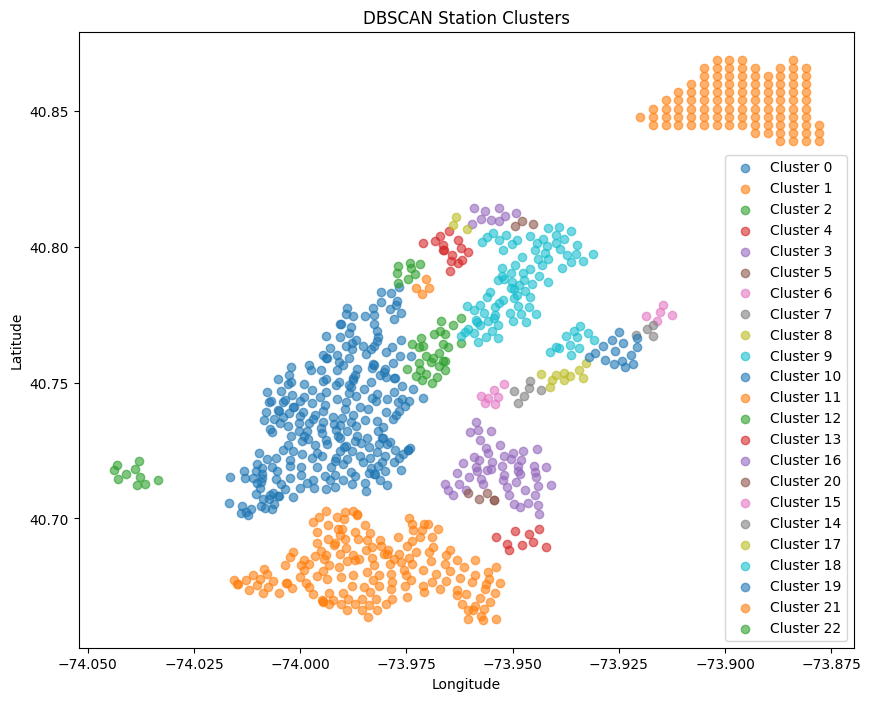

{'n_points': 955, 'n_points_total': 957, 'n_noise': 2, 'n_clusters': 21, 'distortion_sse': 0.09403009087362307, 'distortion_per_point': 9.846082813991945e-05, 'silhouette': 0.43697479628403163}


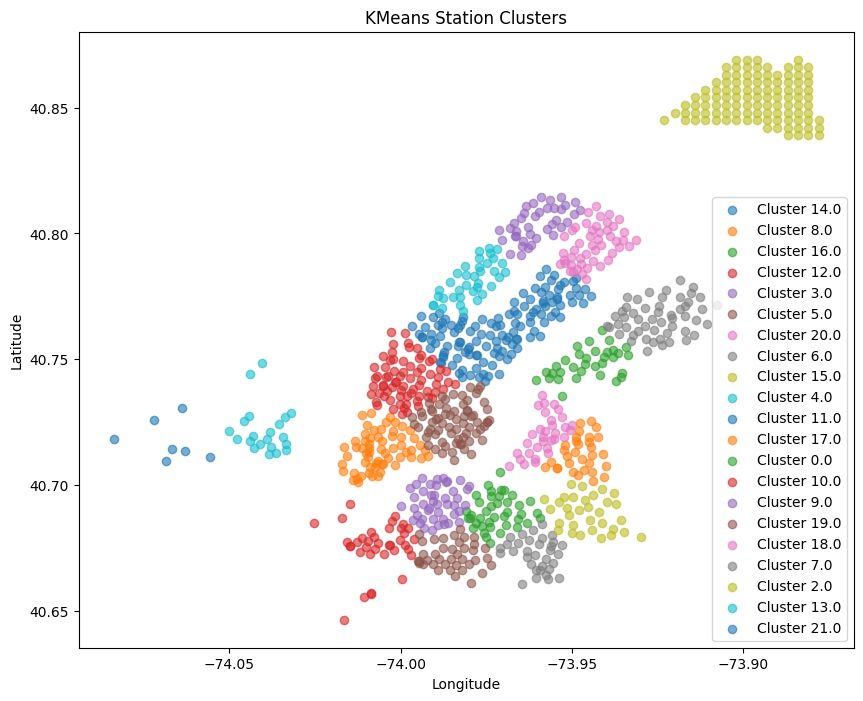

In [77]:
clustered_stations_dbscan = cluster_stations_dbscan(stations, eps=0.0037, min_samples=4, mark_noise=True)
eval_dbscan_stat, clustered_stations_dbscan = evaluate_station_clustering(clustered_stations_dbscan, drop_noise=True)
print(eval_dbscan_stat)
plot_clusters(clustered_stations_dbscan, "DBSCAN Station Clusters")

clustered_stations_kmeans = cluster_stations_kmeans(stations, K=22, min_samples=4, mark_noise=True)
eval_kmeans_stat, clustered_stations_kmeans = evaluate_station_clustering(clustered_stations_kmeans, drop_noise=True)
print(eval_kmeans_stat)
plot_clusters(clustered_stations_kmeans, "KMeans Station Clusters")

In [78]:
def map_trips_to_station_clusters(df: pd.DataFrame, clustered_stations: pd.DataFrame, ) -> pd.DataFrame:
    df_mapped = df.copy()

    # create a mapping from coordinate tuple -> station_uid and add uid columns to trips df
    coord_to_cluster = { (row.latitude, row.longitude): row.cluster for row in clustered_stations.itertuples() }

    # vectorized creation of coordinate tuples and mapping
    df_mapped['start_coord'] = list(zip(df_mapped['start_station_latitude'], df_mapped['start_station_longitude']))
    df_mapped['end_coord'] = list(zip(df_mapped['end_station_latitude'], df_mapped['end_station_longitude']))

    df_mapped['start_cluster'] = df_mapped['start_coord'].map(coord_to_cluster)
    df_mapped['end_cluster'] = df_mapped['end_coord'].map(coord_to_cluster)

    # cleanup temporary columns if you don't want to keep them
    df_mapped.drop(columns=['start_station_id', 'end_station_id', 'start_coord', 'end_coord', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'], inplace=True)

    return df_mapped

df_dbscan_clustered = map_trips_to_station_clusters(df, clustered_stations_dbscan)
df_kmeans_clustered = map_trips_to_station_clusters(df, clustered_stations_kmeans)

In [79]:
def evaluate_clustering(df: pd.DataFrame):
    total_trips = len(df)
    mapped_trips = df.dropna(subset=['start_cluster', 'end_cluster'])
    num_mapped_trips = len(mapped_trips)
    mapping_rate = num_mapped_trips / total_trips * 100

    print(f"Total trips: {total_trips}")
    print(f"Mapped trips: {num_mapped_trips}")
    print(f"Mapping rate: {mapping_rate:.2f}%")

print("\nDBSCAN Clustered Trips Evaluation:")
evaluate_clustering(df_dbscan_clustered)

df_dbscan_clustered.dropna(subset=['start_cluster', 'end_cluster'], inplace=True)

print("\nKMeans Clustered Trips Evaluation:")
evaluate_clustering(df_kmeans_clustered)

df_kmeans_clustered.dropna(subset=['start_cluster', 'end_cluster'], inplace=True)



DBSCAN Clustered Trips Evaluation:
Total trips: 17548339
Mapped trips: 15169112
Mapping rate: 86.44%

KMeans Clustered Trips Evaluation:
Total trips: 17548339
Mapped trips: 17548257
Mapping rate: 100.00%


In [96]:
df_kmeans_clustered.head() 

,tripduration,starttime,stoptime,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,31956,Subscriber,1992,1,14.0,14.0
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,32536,Subscriber,1969,1,14.0,12.0
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,16069,Subscriber,1956,1,14.0,12.0
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,31781,Subscriber,1974,1,14.0,14.0
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,30319,Subscriber,1992,1,14.0,4.0


---
## DATE TIME

In [83]:
def validate_tripduration(df: pd.DataFrame) -> None:
    # validate tripduration vs stoptime - starttime
    # convert to datetime if needed
    if df['starttime'].dtype == object:
        df['starttime'] = pd.to_datetime(df['starttime'])
    if df['stoptime'].dtype == object:
        df['stoptime'] = pd.to_datetime(df['stoptime'])

    # compute durations (seconds)
    #df['computed_duration'] = (df['stoptime'] - df['starttime']).dt.total_seconds()
    computed_duration = (df['stoptime'] - df['starttime']).dt.total_seconds()


    # summary comparisons
    n_total = len(df)
    n_exact = (df['tripduration'] == computed_duration).sum()
    n_rounded = (df['tripduration'] == computed_duration.round()).sum()
    n_within1 = (df['tripduration'] - computed_duration).abs().le(1).sum()
    n_diff_gt1 = (df['tripduration'] - computed_duration).abs().gt(1).sum()


    print("Trip Duration Validation Summary:")
    print(f"total rows: {n_total}")
    print(f"exact float match: {n_exact} ({n_exact/n_total:.2%})")
    print(f"match after rounding computed duration: {n_rounded} ({n_rounded/n_total:.2%})")
    print(f"within 1s tolerance: {n_within1} ({n_within1/n_total:.2%})")
    print(f"differences > 1s: {n_diff_gt1} ({n_diff_gt1/n_total:.2%})")

    # Find trips where starttime is later than stoptime
    invalid_trips = df[df['starttime'] > df['stoptime']]

    print(f"\nNumber of invalid trips (start > stop): {len(invalid_trips)}")
    if len(invalid_trips) > 0:
        print("\nSample of invalid trips:")
        display(invalid_trips[['starttime', 'stoptime', 'tripduration']].head())
    else:
        print("No invalid trips found.")


validate_tripduration(df)

Trip Duration Validation Summary:
total rows: 17548339
exact float match: 17545 (0.10%)
match after rounding computed duration: 8784724 (50.06%)
within 1s tolerance: 17548188 (100.00%)
differences > 1s: 151 (0.00%)

Number of invalid trips (start > stop): 0
No invalid trips found.


In [84]:
def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create time-based features from starttime and stoptime columns."""
    df_hours = df.copy()

    df_hours['starttime'] = pd.to_datetime(df_hours['starttime'])
    df_hours['stoptime'] = pd.to_datetime(df_hours['stoptime'])

    # Create hour features from starttime and stoptime
    # Create hour features rounded down to the hour (date + hour:00)
    df_hours['start_datetime_hour'] = df_hours['starttime'].dt.floor('h')
    df_hours['stop_datetime_hour'] = df_hours['stoptime'].dt.floor('h')

    df_hours.drop(["starttime", "stoptime"], axis=1, inplace=True)

    return df_hours

df_times_clustered = create_time_features(df_kmeans_clustered)

In [ ]:
df_times_clustered.drop(['usertype', 'birth_year', 'gender', 'bikeid', 'tripduration'], axis=1, inplace=True)

KeyError: "['usertype', 'birth_year', 'gender', 'bikeid', 'trip_duration'] not found in axis"

In [135]:
df_times_clustered.head()

,start_cluster,end_cluster,start_datetime_hour,stop_datetime_hour
0,14.0,14.0,2018-01-01 13:00:00,2018-01-01 14:00:00
1,14.0,12.0,2018-01-01 15:00:00,2018-01-01 15:00:00
2,14.0,12.0,2018-01-01 15:00:00,2018-01-01 15:00:00
3,14.0,14.0,2018-01-01 15:00:00,2018-01-01 15:00:00
4,14.0,4.0,2018-01-01 18:00:00,2018-01-01 18:00:00


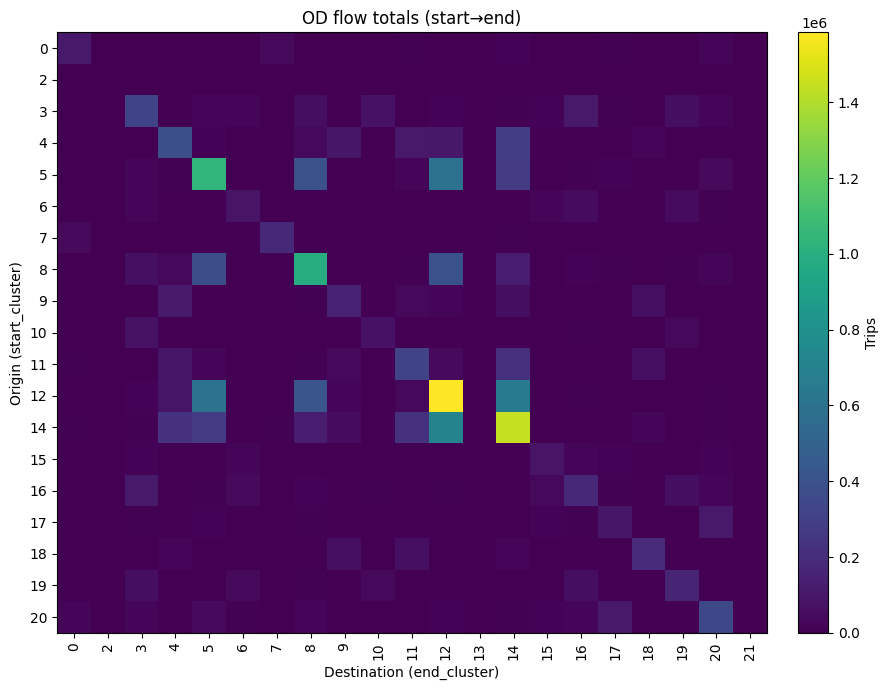

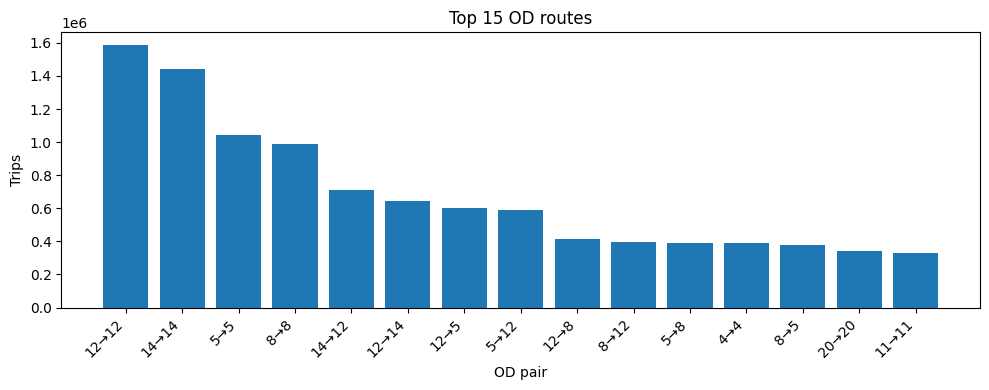

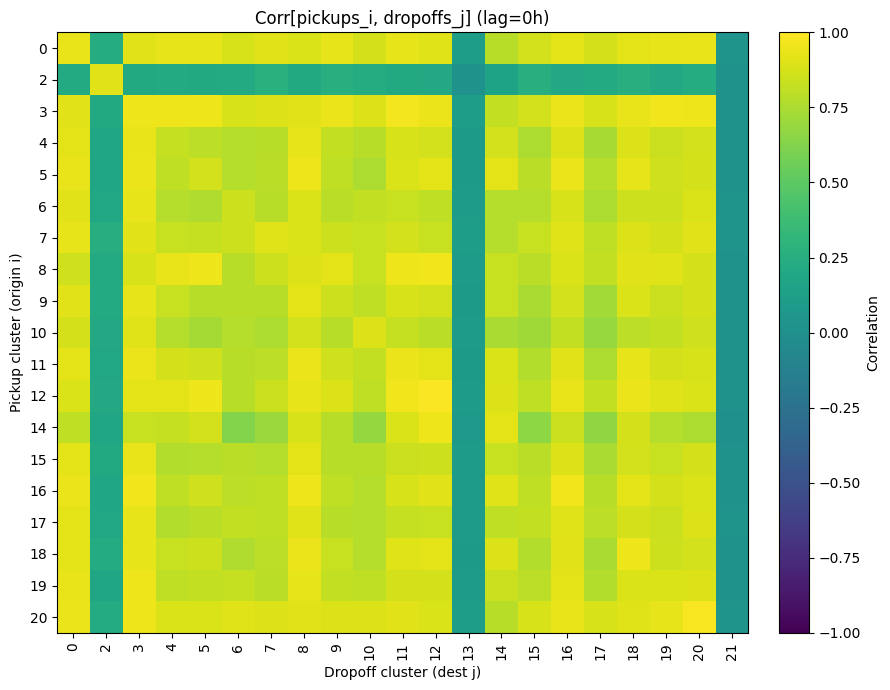

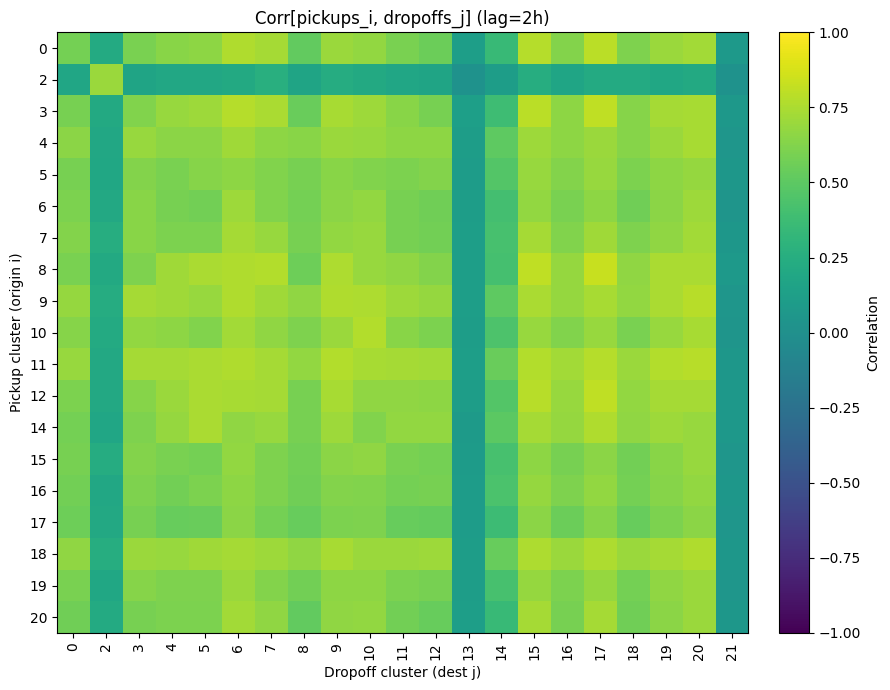

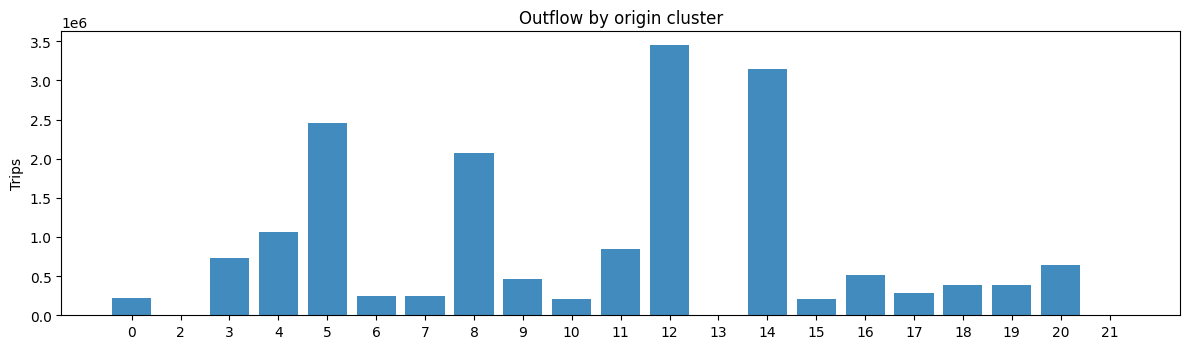

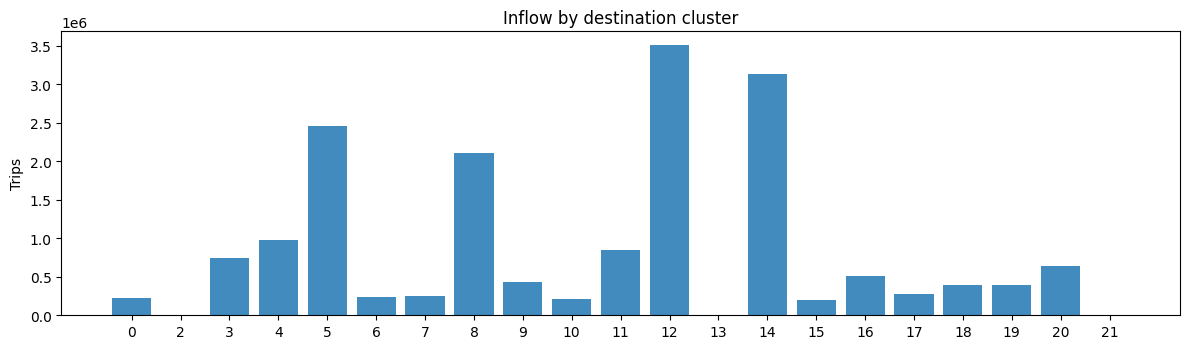

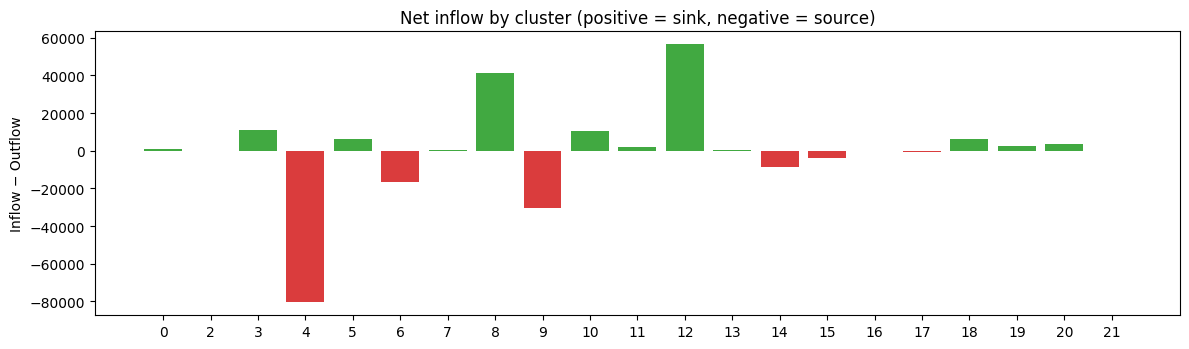

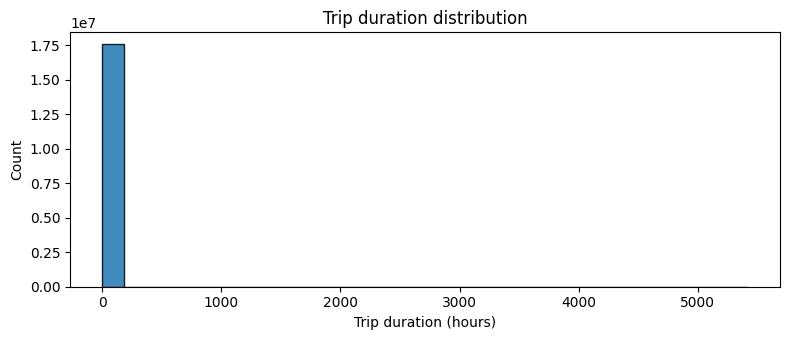

In [136]:
# ================= OD flows: totals, correlations, and more =================
# Expects a DataFrame `od` with columns:
# ['start_cluster','end_cluster','start_datetime_hour','stop_datetime_hour']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _to_dt(x): 
    return pd.to_datetime(x, errors="coerce")

def _fmt_cluster_labels(vals):
    labs = []
    for v in vals:
        try:
            fv = float(v)
            labs.append(str(int(fv)) if fv.is_integer() else str(fv))
        except Exception:
            labs.append(str(v))
    return labs

def prepare_od(od: pd.DataFrame):
    od = od.copy()
    od["start_datetime_hour"] = _to_dt(od["start_datetime_hour"])
    od["stop_datetime_hour"]  = _to_dt(od["stop_datetime_hour"])
    # ensure clusters are consistent types
    # (keep as-is; only cast for labels when plotting)
    return od

def od_totals_matrix(od: pd.DataFrame) -> pd.DataFrame:
    """Total flows from start_cluster -> end_cluster across the full period."""
    mat = (od
           .groupby(["start_cluster","end_cluster"])
           .size()
           .unstack("end_cluster", fill_value=0))
    # sort rows/cols numerically if possible
    try:
        mat = mat.reindex(sorted(mat.index, key=lambda x: float(x)))
        mat = mat.reindex(sorted(mat.columns, key=lambda x: float(x)), axis=1)
    except Exception:
        pass
    return mat

def hourly_origin_matrix(od: pd.DataFrame) -> pd.DataFrame:
    """Time x origin-cluster: counts of departures each hour."""
    w = (od
         .groupby(["start_datetime_hour","start_cluster"])
         .size()
         .unstack("start_cluster", fill_value=0))
    return w.sort_index()

def hourly_dest_matrix(od: pd.DataFrame) -> pd.DataFrame:
    """Time x destination-cluster: counts of arrivals each hour."""
    w = (od
         .groupby(["stop_datetime_hour","end_cluster"])
         .size()
         .unstack("end_cluster", fill_value=0))
    return w.sort_index()

def od_corr_pickups_vs_dropoffs(od: pd.DataFrame, lag_hours: int = 0, method: str = "pearson") -> pd.DataFrame:
    """
    Corr between origin pickups at cluster i and destination dropoffs at cluster j.
    If lag_hours>0: correlate pickups(t) vs dropoffs(t+lag).
    """
    P = hourly_origin_matrix(od)        # time x origin
    D = hourly_dest_matrix(od)          # time x dest
    if lag_hours != 0:
        D = D.shift(-lag_hours, freq=None)  # align P(t) with D(t+lag)

    # align time index
    common = P.index.intersection(D.index)
    P, D = P.loc[common], D.loc[common]

    # drop constant columns (std==0) to avoid NaN corr
    P = P.loc[:, P.std(ddof=0) > 0]
    D = D.loc[:, D.std(ddof=0) > 0]

    # compute corr matrix: rows=origins, cols=destinations
    mat = pd.DataFrame(index=P.columns, columns=D.columns, dtype=float)
    for dcol in D.columns:
        mat[dcol] = P.corrwith(D[dcol], axis=0, method=method)
    # sort indices/cols numerically if possible
    try:
        mat = mat.reindex(sorted(mat.index, key=lambda x: float(x)))
        mat = mat.reindex(sorted(mat.columns, key=lambda x: float(x)), axis=1)
    except Exception:
        pass
    return mat

# ---------- plots ----------
def plot_od_heatmap(od_matrix: pd.DataFrame, title="OD flow totals"):
    fig = plt.figure(figsize=(9,7)); ax = plt.gca()
    im = ax.imshow(od_matrix.values, aspect="auto")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04); cbar.set_label("Trips")

    ax.set_yticks(range(od_matrix.shape[0]))
    ax.set_xticks(range(od_matrix.shape[1]))
    ax.set_yticklabels(_fmt_cluster_labels(od_matrix.index))
    ax.set_xticklabels(_fmt_cluster_labels(od_matrix.columns), rotation=90)

    ax.set_ylabel("Origin (start_cluster)")
    ax.set_xlabel("Destination (end_cluster)")
    ax.set_title(title)
    plt.tight_layout()

def plot_top_od_pairs(od: pd.DataFrame, k: int = 15, title=None):
    pairs = (od.groupby(["start_cluster","end_cluster"]).size()
             .sort_values(ascending=False).head(k))
    labs = [f"{_fmt_cluster_labels([i])[0]}→{_fmt_cluster_labels([j])[0]}" for i,j in pairs.index]
    plt.figure(figsize=(10,4)); ax = plt.gca()
    ax.bar(np.arange(len(pairs)), pairs.values)
    ax.set_xticks(np.arange(len(pairs))); ax.set_xticklabels(labs, rotation=45, ha="right")
    ax.set_ylabel("Trips"); ax.set_xlabel("OD pair")
    ax.set_title(title or f"Top {k} OD routes")
    plt.tight_layout()

def plot_corr_heatmap(corr: pd.DataFrame, title="Corr[pickups_i, dropoffs_j]"):
    fig = plt.figure(figsize=(9,7)); ax = plt.gca()
    im = ax.imshow(corr.values, aspect="auto", vmin=-1, vmax=1)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04); cbar.set_label("Correlation")

    ax.set_yticks(range(corr.shape[0]))
    ax.set_xticks(range(corr.shape[1]))
    ax.set_yticklabels(_fmt_cluster_labels(corr.index))
    ax.set_xticklabels(_fmt_cluster_labels(corr.columns), rotation=90)
    ax.set_ylabel("Pickup cluster (origin i)")
    ax.set_xlabel("Dropoff cluster (dest j)")
    ax.set_title(title)
    plt.tight_layout()

def plot_in_out_net(od: pd.DataFrame):
    outflow = od.groupby("start_cluster").size().rename("outflow")
    inflow  = od.groupby("end_cluster").size().rename("inflow")
    flow = pd.concat([outflow, inflow], axis=1).fillna(0.0)
    flow["net_inflow"] = flow["inflow"] - flow["outflow"]
    flow = flow.sort_index(key=lambda x: [float(v) if pd.notna(v) else v for v in x])

    labs = _fmt_cluster_labels(flow.index)

    plt.figure(figsize=(12,3.6)); 
    plt.bar(np.arange(len(flow)), flow["outflow"].values, alpha=0.85)
    plt.xticks(np.arange(len(flow)), labs, rotation=0); plt.ylabel("Trips")
    plt.title("Outflow by origin cluster"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12,3.6)); 
    plt.bar(np.arange(len(flow)), flow["inflow"].values, alpha=0.85)
    plt.xticks(np.arange(len(flow)), labs, rotation=0); plt.ylabel("Trips")
    plt.title("Inflow by destination cluster"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12,3.6)); 
    colors = np.where(flow["net_inflow"].values >= 0, "tab:green", "tab:red")
    plt.bar(np.arange(len(flow)), flow["net_inflow"].values, color=colors, alpha=0.9)
    plt.xticks(np.arange(len(flow)), labs, rotation=0); plt.ylabel("Inflow − Outflow")
    plt.title("Net inflow by cluster (positive = sink, negative = source)")
    plt.tight_layout(); plt.show()

def plot_duration_hist(od: pd.DataFrame, bins=30):
    dur = (od["stop_datetime_hour"] - od["start_datetime_hour"]).dt.total_seconds() / 3600.0
    dur = dur.dropna()
    plt.figure(figsize=(8,3.5))
    plt.hist(dur, bins=bins, edgecolor="black", alpha=0.85)
    plt.xlabel("Trip duration (hours)"); plt.ylabel("Count")
    plt.title("Trip duration distribution"); plt.tight_layout(); plt.show()

# ================= RUN on your data =================
# od = <your DataFrame with the four columns>
od = prepare_od(df_times_clustered)

# 1) OD totals (from where → to where)
mat_tot = od_totals_matrix(od)
plot_od_heatmap(mat_tot, title="OD flow totals (start→end)")
plt.show()

# 2) Top OD routes
plot_top_od_pairs(od, k=15)
plt.show()

# 3) Pickup at i vs Dropoff at j correlations (same-hour)
corr0 = od_corr_pickups_vs_dropoffs(od, lag_hours=0, method="pearson")
plot_corr_heatmap(corr0, title="Corr[pickups_i, dropoffs_j] (lag=0h)")
plt.show()

# Optional: with delay (e.g., 1–3h) if you believe trips span hours
corr2 = od_corr_pickups_vs_dropoffs(od, lag_hours=2, method="pearson")
plot_corr_heatmap(corr2, title="Corr[pickups_i, dropoffs_j] (lag=2h)")
plt.show()

# 4) Inflow / Outflow / Net by cluster
plot_in_out_net(od)

# 5) Trip duration distribution
plot_duration_hist(od, bins=30)


---

## DEMAND

In [108]:
def convert_pickup_dropoff_to_demand(df: pd.DataFrame) -> pd.DataFrame:
    """Convert pickup/dropoff data to demand data per hour/cluster."""

    # pickups per hour/cluster
    pick = (
        df[['start_datetime_hour', 'start_cluster']]
        .groupby(['start_datetime_hour', 'start_cluster'])
        .size()
        .reset_index(name='pickups')
        .rename(columns={'start_datetime_hour': 'datetime', 'start_cluster': 'cluster'})
    )

    # dropoffs per hour/cluster
    drop = (
        df[['stop_datetime_hour', 'end_cluster']]
        .groupby(['stop_datetime_hour', 'end_cluster'])
        .size()
        .reset_index(name='dropoffs')
        .rename(columns={'stop_datetime_hour': 'datetime', 'end_cluster': 'cluster'})
    )

    # merge pickups and dropoffs, fill missing with 0
    df_demand = pd.merge(pick, drop, on=['datetime', 'cluster'], how='outer').fillna(0)
    df_demand['pickups'] = df_demand['pickups'].astype(int)
    df_demand['dropoffs'] = df_demand['dropoffs'].astype(int)
    df_demand['demand'] = df_demand['pickups'] + df_demand['dropoffs']
    df_demand['datetime'] = pd.to_datetime(df_demand['datetime'])

    # result: `agg` with datetime index and one row per (datetime, cluster)
    return df_demand

df_demand = convert_pickup_dropoff_to_demand(df_times_clustered)

In [111]:
df_demand.head()

,datetime,cluster,pickups,dropoffs,demand
0,2018-01-01,0.0,1,0,1
1,2018-01-01,3.0,2,1,3
2,2018-01-01,4.0,8,4,12
3,2018-01-01,5.0,18,20,38
4,2018-01-01,6.0,3,0,3


def generate_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

df_demand = generate_time_features(df_demand)
df_demand.head()

In [121]:
# set datetime as index
df_demand.set_index('datetime', inplace=True)
df_demand.head()

,cluster,pickups,dropoffs,demand
datetime,,,,
2018-01-01,0.0,1,0,1
2018-01-01,3.0,2,1,3
2018-01-01,4.0,8,4,12
2018-01-01,5.0,18,20,38
2018-01-01,6.0,3,0,3


In [122]:
df_demand.head()


,cluster,pickups,dropoffs,demand
datetime,,,,
2018-01-01,0.0,1,0,1
2018-01-01,3.0,2,1,3
2018-01-01,4.0,8,4,12
2018-01-01,5.0,18,20,38
2018-01-01,6.0,3,0,3


C:\Users\Tomi\AppData\Local\Temp\ipykernel_32732\460659529.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = plt.cm.get_cmap('tab20', 20)


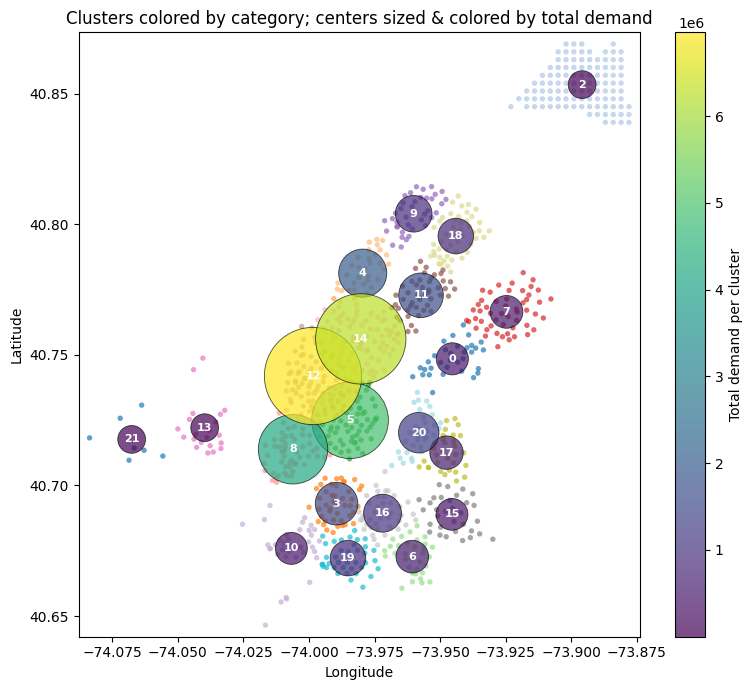

In [123]:
def plot_clustered_demand_map(
    df_demand: pd.DataFrame,
    clustered_stations_kmeans: pd.DataFrame
):
    #Sum total demand per cluster (across whole dataset)
    cluster_total = (df_demand
                    .groupby('cluster', as_index=False)['demand']
                    .sum())

    #Compute cluster centers from stations (mean lat/lon per cluster)
    cluster_centers = (clustered_stations_kmeans
                    .groupby('cluster')[['latitude','longitude']]
                    .mean())

    #Merge totals with centers; drop clusters with no coordinates (and optional: drop noise = -1)
    plot_df = (cluster_total
            .merge(cluster_centers.reset_index(), on='cluster', how='left')
            .dropna(subset=['latitude','longitude']))
    plot_df = plot_df[plot_df['cluster'] != -1]  # comment out if you want to keep noise

    #Prepare size & color by demand (continuous colormap)
    max_d = plot_df['demand'].max()
    min_d = plot_df['demand'].min()

    # matplotlib 's' is area (points^2). We'll scale smoothly with demand.
    sizes = ((plot_df['demand'] / max_d) * 50 + 20)**2

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min_d, vmax=max_d)

    #Background: plot all stations colored by cluster (categorical)
    stations_bg = clustered_stations_kmeans.copy()
    stations_bg = stations_bg.dropna(subset=['latitude','longitude'])
    stations_bg = stations_bg[stations_bg['cluster'] != -1]  # drop noise from background

    unique_clusters = np.sort(stations_bg['cluster'].unique())
    tab20 = plt.cm.get_cmap('tab20', 20)
    cluster_colors = {c: tab20(int(i % 20)) for i, c in enumerate(unique_clusters)}

    #Plot
    fig, ax = plt.subplots(figsize=(8, 7))

    # background station points by cluster (faint)
    ax.scatter(
        stations_bg['longitude'].values,
        stations_bg['latitude'].values,
        c=[cluster_colors[c] for c in stations_bg['cluster'].values],
        s=15, alpha=0.7, linewidths=0
    )

    # overlay cluster centers sized & colored by total demand (with outline)
    sc = ax.scatter(
        plot_df['longitude'].values,
        plot_df['latitude'].values,
        s=sizes.values,
        c=plot_df['demand'].values,
        cmap=cmap, norm=norm,
        edgecolor='black', linewidths=0.6, alpha=0.70,
        zorder=3
    )

    # optional: annotate cluster IDs on centers
    for _, r in plot_df.iterrows():
        ax.text(r['longitude'], r['latitude'], f"{int(r['cluster'])}",
                fontsize=8, ha='center', va='center', color='white', weight='bold', zorder=4)

    # colorbar for demand
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Total demand per cluster')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Clusters colored by category; centers sized & colored by total demand')

    # make the lon/lat map look right-ish
    ax.set_aspect('equal', adjustable='datalim')
    ax.margins(0.02)
    plt.tight_layout()
    plt.show()

plot_clustered_demand_map(df_demand, clustered_stations_kmeans)


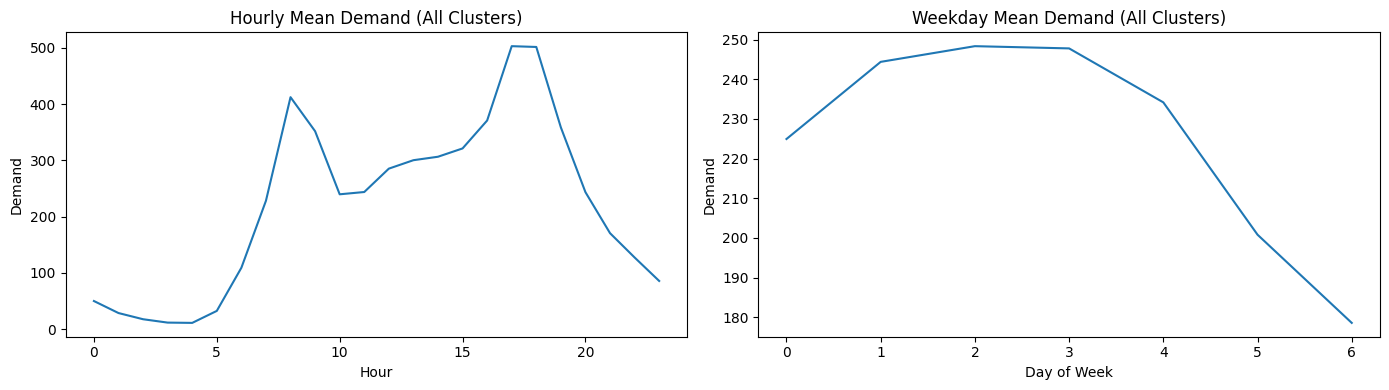

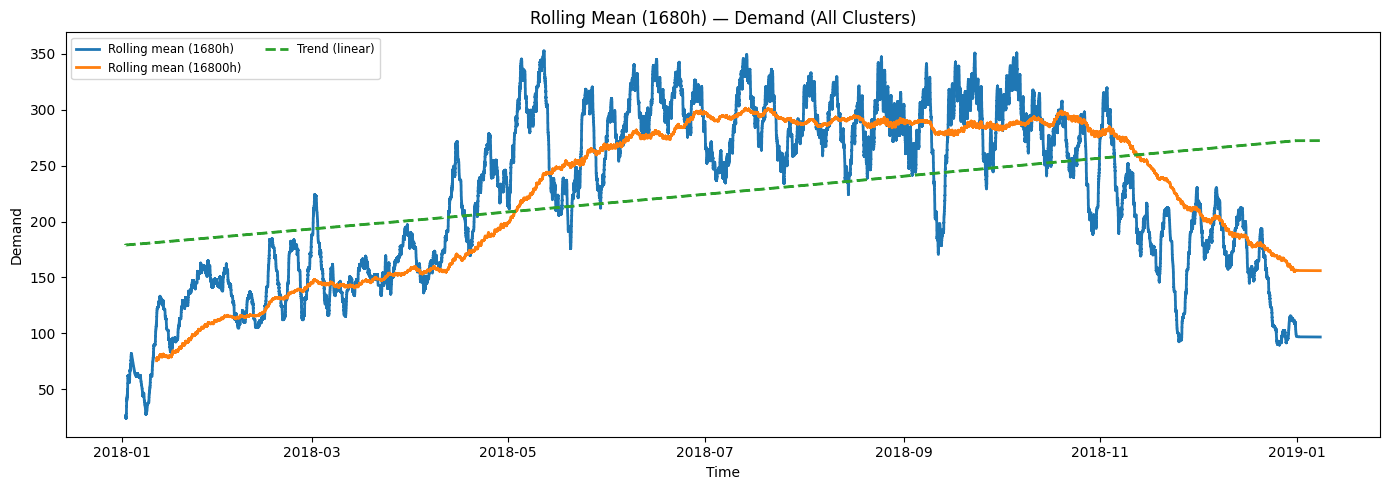

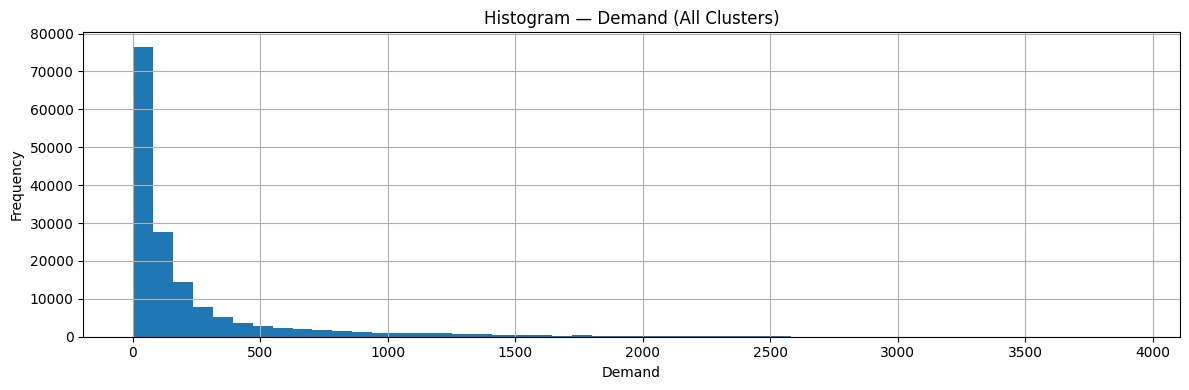

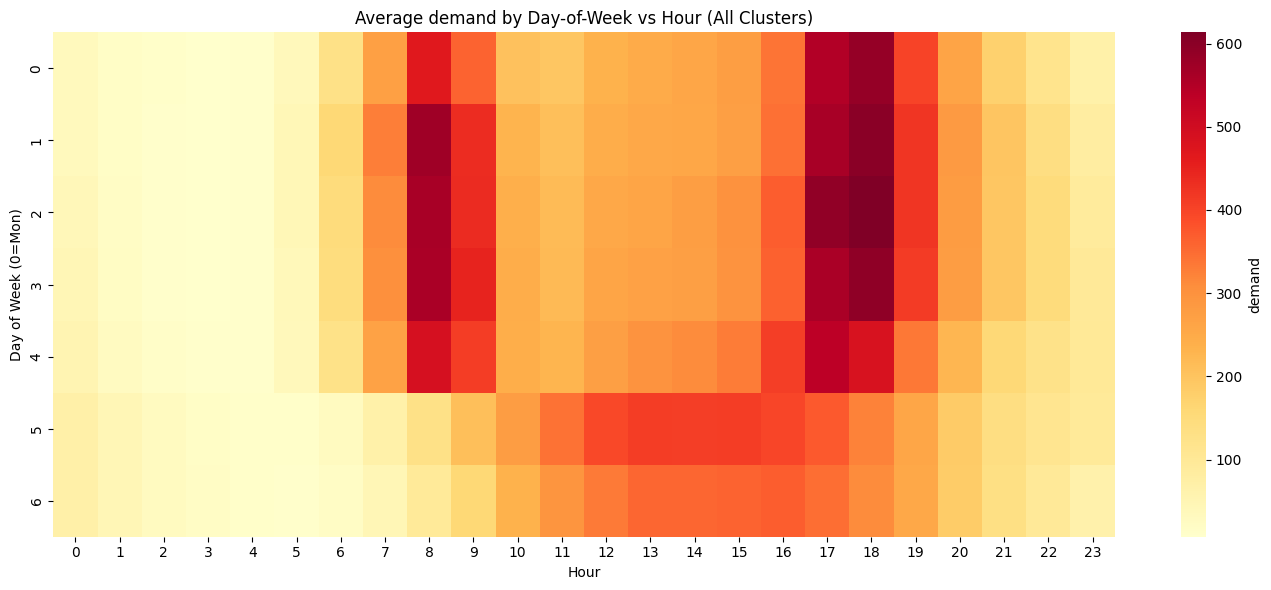

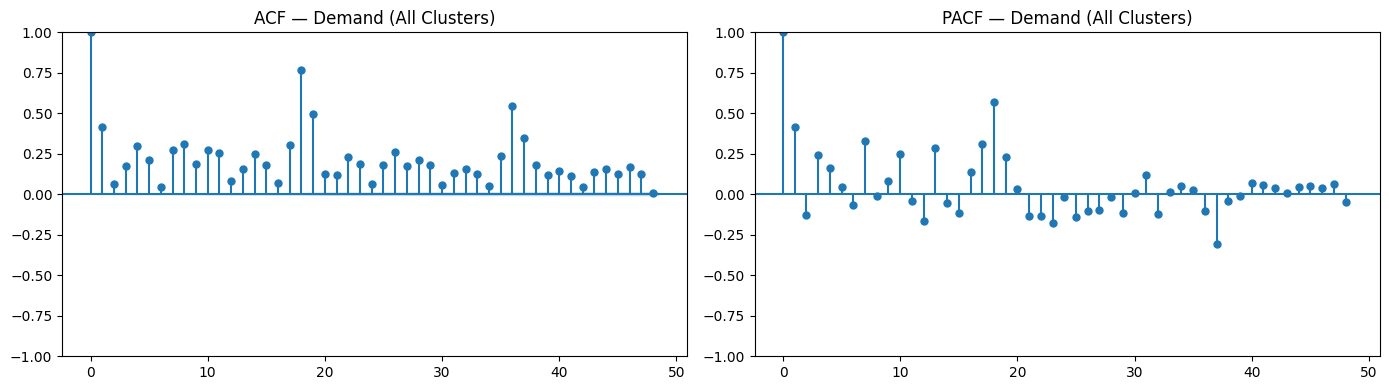

In [95]:

def plot_demand_time_series_analysis(df_demand: pd.DataFrame):

    def calendar_heatmap(ts, value_col="demand", title_suffix=""):
        d = ts.copy()
        d["hour"] = d.index.hour
        d["dow"]  = d.index.dayofweek
        pivot = d.pivot_table(index="dow", columns="hour", values=value_col, aggfunc="mean")
        plt.figure(figsize=(14, 6))
        sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': value_col})
        plt.title(f"Average {value_col} by Day-of-Week vs Hour {title_suffix}")
        plt.xlabel("Hour"); plt.ylabel("Day of Week (0=Mon)")
        plt.tight_layout()

    def seasonal_lineplots(ts, title_suffix=""):
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        ts.groupby(ts.index.hour)["demand"].mean().plot(ax=axes[0])
        axes[0].set_title(f"Hourly Mean Demand {title_suffix}"); axes[0].set_xlabel("Hour"); axes[0].set_ylabel("Demand")

        ts.groupby(ts.index.dayofweek)["demand"].mean().plot(ax=axes[1])
        axes[1].set_title(f"Weekday Mean Demand {title_suffix}"); axes[1].set_xlabel("Day of Week"); axes[1].set_ylabel("Demand")
        plt.tight_layout()

    def rolling_stats(ts, window=1680, title_suffix=""):
        import numpy as np
        import matplotlib.pyplot as plt

        # rolling mean of demand
        s = ts["demand"].astype(float)
        rm = s.rolling(window, min_periods=max(1, window // 4)).mean()

        plt.figure(figsize=(14, 5))
        # main line: rolling mean
        plt.plot(rm.index, rm.values, linewidth=2.0, label=f"Rolling mean ({window}h)")
        rm2 = s.rolling(window*10, min_periods=max(1, (window*10) // 4)).mean()
        plt.plot(rm2.index, rm2.values, linewidth=2.0, label=f"Rolling mean ({window*10}h)")

        # trend line (linear fit over the rolling mean)
        valid = rm.notna()
        if valid.sum() > 1:
            x = np.arange(valid.sum())
            y = rm[valid].to_numpy()
            coef = np.polyfit(x, y, 1)
            yhat = coef[0] * x + coef[1]
            plt.plot(rm.index[valid], yhat, linestyle="--", linewidth=2.0, label="Trend (linear)")

        plt.title(f"Rolling Mean ({window}h) — Demand {title_suffix}")
        plt.xlabel("Time")
        plt.ylabel("Demand")
        plt.legend(loc="upper left", ncol=2, fontsize="small")
        plt.tight_layout()


    def distribution_plots(ts, title_suffix=""):
        plt.figure(figsize=(12, 4))
        ts["demand"].hist(bins=50)
        plt.title(f"Histogram — Demand {title_suffix}"); plt.xlabel("Demand"); plt.ylabel("Frequency")
        plt.tight_layout()

    def correlation_plots(ts, title_suffix=""):
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        plot_acf(ts["demand"], lags=48, ax=axes[0]); axes[0].set_title(f"ACF — Demand {title_suffix}")
        plot_pacf(ts["demand"], lags=48, ax=axes[1]); axes[1].set_title(f"PACF — Demand {title_suffix}")
        plt.tight_layout()

    seasonal_lineplots(df_demand, "(All Clusters)")
    rolling_stats(df_demand, title_suffix="(All Clusters)")
    distribution_plots(df_demand, title_suffix="(All Clusters)")
    calendar_heatmap(df_demand, "demand", "(All Clusters)")
    correlation_plots(df_demand, title_suffix="(All Clusters)")

plot_demand_time_series_analysis(df_demand)

,cluster,mean,std,total,peak,active_periods,share_of_total_%,autocorr_lag24
0,12.0,793.133910,745.430751,6965302.0,3852.0,8750,19.846136,0.814134
1,14.0,714.525734,727.604109,6274965.0,3912.0,8745,17.879169,0.767767
2,5.0,558.994876,484.847981,4909093.0,2595.0,8745,13.987409,0.813954
3,8.0,475.337167,492.080457,4174411.0,2480.0,8737,11.894090,0.806453
4,4.0,232.170804,225.303384,2038924.0,1194.0,8676,5.809477,0.780340
5,11.0,191.723298,179.861497,1683714.0,936.0,8643,4.797382,0.795113
6,3.0,169.011842,165.545232,1484262.0,811.0,8636,4.229087,0.794761
7,20.0,145.259394,140.349236,1275668.0,816.0,8577,3.634743,0.763578
8,16.0,115.934753,104.724788,1018139.0,553.0,8645,2.900969,0.781042
9,9.0,101.873036,98.506945,894649.0,470.0,8618,2.549111,0.787604


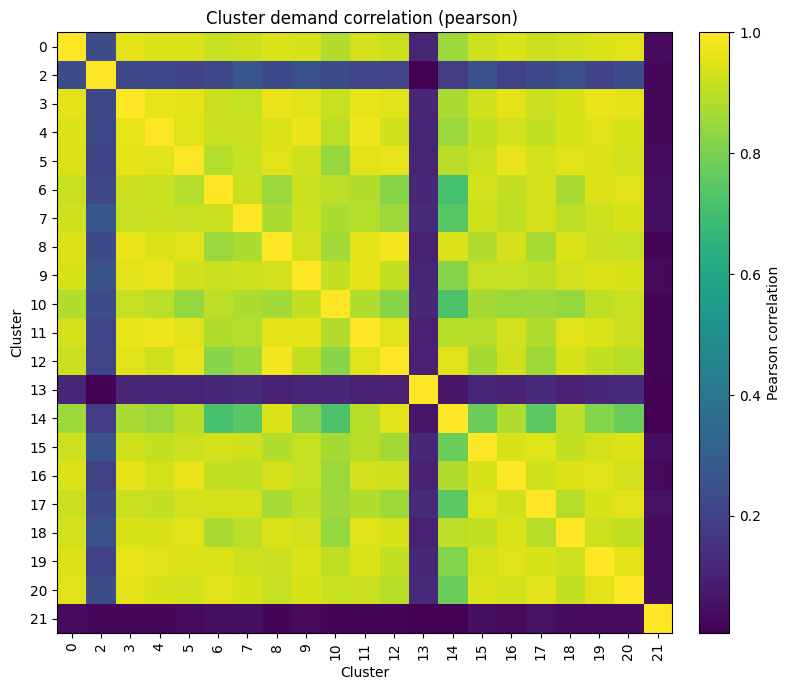

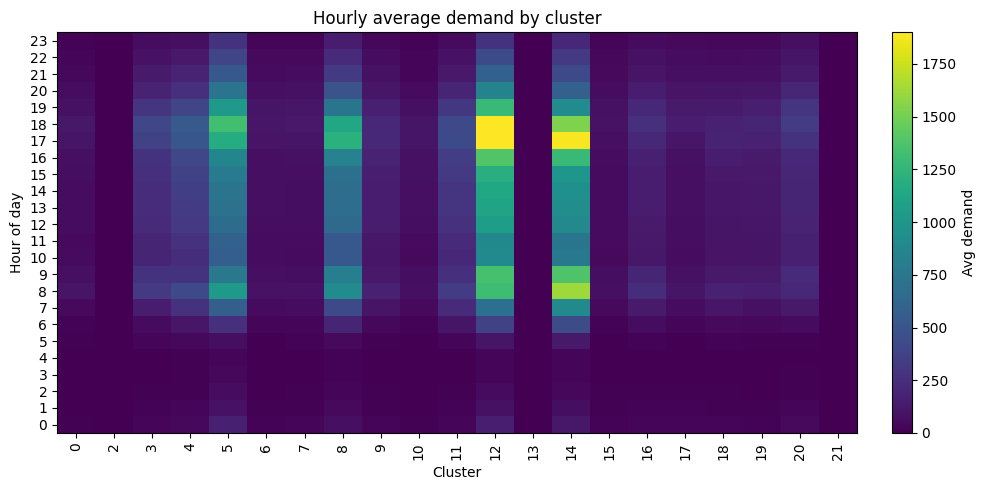

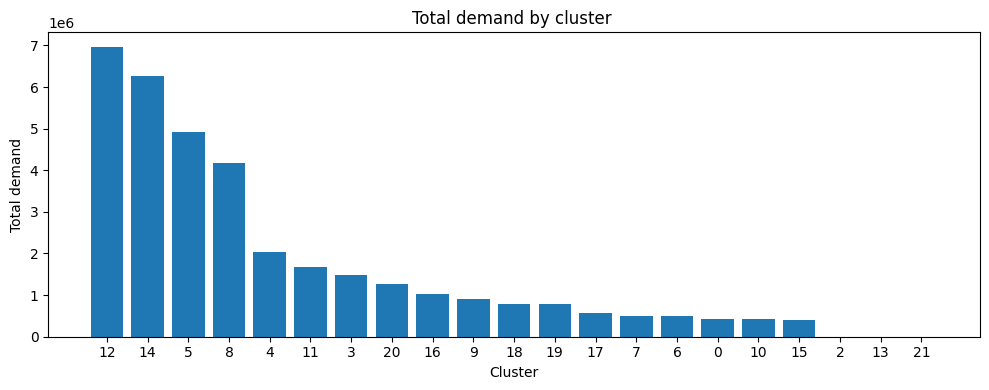

,cluster_i,cluster_j,corr
122,8.0,12.0,0.983009
63,4.0,11.0,0.974661
61,4.0,9.0,0.972670
84,5.0,16.0,0.967143
43,3.0,8.0,0.966845
54,3.0,19.0,0.966580
80,5.0,12.0,0.963832
39,3.0,4.0,0.963281
46,3.0,11.0,0.963080
207,19.0,20.0,0.961117


In [127]:
# ================== Cluster demand metrics & visuals (no predictions) ==================
# Expects a DataFrame 'df' where:
#  - index is datetime
#  - columns: ['cluster','pickups','dropoffs','demand']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Wide matrices (time x cluster)
def build_cluster_wide(df: pd.DataFrame, value_col: str = "demand") -> pd.DataFrame:
    w = df.pivot_table(index=df.index, columns="cluster", values=value_col, aggfunc="sum", fill_value=0)
    # sort columns numerically if possible
    try:
        w = w.reindex(sorted(w.columns, key=lambda x: float(x)), axis=1)
    except Exception:
        pass
    return w

wide_demand  = build_cluster_wide(df_demand, "demand")
wide_pickups = build_cluster_wide(df_demand, "pickups")
wide_dropoff = build_cluster_wide(df_demand, "dropoffs")

# 2) Per-cluster metrics (level, variability, activity, share, seasonality proxy)
def _seasonal_lag(idx: pd.DatetimeIndex) -> int:
    if len(idx) > 1:
        step_h = np.median(np.diff(idx.values).astype("timedelta64[h]").astype(float))
        if step_h <= 1.5:  # hourly cadence
            return 24
    return 7

def cluster_demand_metrics(wide: pd.DataFrame) -> pd.DataFrame:
    lag = _seasonal_lag(wide.index)
    rows = []
    total_all = wide.sum().sum()
    for c in wide.columns:
        s = wide[c].astype(float)
        total = s.sum()
        rows.append({
            "cluster": c,
            "mean": s.mean(),
            "std": s.std(ddof=1),
            "total": total,
            "peak": s.max(),
            "active_periods": int((s > 0).sum()),
            "share_of_total_%": (total / (total_all + 1e-12)) * 100.0,
            f"autocorr_lag{lag}": float(s.autocorr(lag)) if len(s) > lag else np.nan
        })
    return pd.DataFrame(rows).sort_values("total", ascending=False).reset_index(drop=True)

metrics = cluster_demand_metrics(wide_demand)
display(metrics.head(15))

# 3) Correlation heatmap (how clusters co-move over time)
def plot_cluster_corr_heatmap(wide: pd.DataFrame, method: str = "pearson", title_suffix: str = ""):
    corr = wide.corr(method=method)
    fig = plt.figure(figsize=(8, 7)); ax = plt.gca()
    im = ax.imshow(corr.values, aspect="auto")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04); cbar.set_label(f"{method.title()} correlation")
    labels = [str(int(c)) if isinstance(c, (int, np.integer, float)) and float(c).is_integer() else str(c)
              for c in corr.columns]
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90); ax.set_yticklabels(labels)
    ax.set_title(f"Cluster demand correlation ({method}) {title_suffix}")
    ax.set_xlabel("Cluster"); ax.set_ylabel("Cluster")
    plt.tight_layout()
    return corr

corr_pearson = plot_cluster_corr_heatmap(wide_demand, method="pearson")
plt.show()

# 4) Hour-of-day profile heatmap (avg demand by hour & cluster)
def plot_hourly_profile_heatmap(df: pd.DataFrame, value_col: str = "demand"):
    g = df.copy()
    g["hour"] = g.index.hour
    prof = g.pivot_table(index="hour", columns="cluster", values=value_col, aggfunc="mean", fill_value=0)
    # keep columns order similar to wide
    try:
        prof = prof.reindex(sorted(prof.columns, key=lambda x: float(x)), axis=1)
    except Exception:
        pass
    fig = plt.figure(figsize=(10, 5)); ax = plt.gca()
    im = ax.imshow(prof.values, aspect="auto", origin="lower")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04); cbar.set_label(f"Avg {value_col}")
    ax.set_yticks(range(0, 24)); ax.set_yticklabels(range(0, 24))
    ax.set_xlabel("Cluster"); ax.set_ylabel("Hour of day")
    ax.set_xticks(range(prof.shape[1]))
    ax.set_xticklabels([str(int(c)) if isinstance(c,(int,np.integer,float)) and float(c).is_integer() else str(c)
                        for c in prof.columns], rotation=90)
    ax.set_title(f"Hourly average {value_col} by cluster")
    plt.tight_layout()

plot_hourly_profile_heatmap(df_demand, value_col="demand")
plt.show()

# 5) Share-of-total bar chart (who contributes most to system demand)
def plot_cluster_total_share(metrics_df: pd.DataFrame, title_suffix=""):
    m = metrics_df.sort_values("total", ascending=False)
    x = np.arange(len(m))
    plt.figure(figsize=(10, 4))
    plt.bar(x, m["total"].values)
    plt.xticks(x, [str(int(c)) if isinstance(c,(int,np.integer,float)) and float(c).is_integer() else str(c)
                   for c in m["cluster"]], rotation=0)
    plt.ylabel("Total demand"); plt.xlabel("Cluster")
    plt.title(f"Total demand by cluster {title_suffix}")
    plt.tight_layout()

plot_cluster_total_share(metrics)
plt.show()

# 6) Optional: top co-moving cluster pairs (based on Pearson corr on demand)
def top_corr_pairs(corr: pd.DataFrame, k: int = 10) -> pd.DataFrame:
    c = corr.copy(); np.fill_diagonal(c.values, np.nan)
    pairs = []
    cols = c.columns.to_list()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            pairs.append((cols[i], cols[j], c.iloc[i, j]))
    out = pd.DataFrame(pairs, columns=["cluster_i","cluster_j","corr"]).sort_values("corr", ascending=False)
    return out.head(k)

display(top_corr_pairs(corr_pearson, k=10))


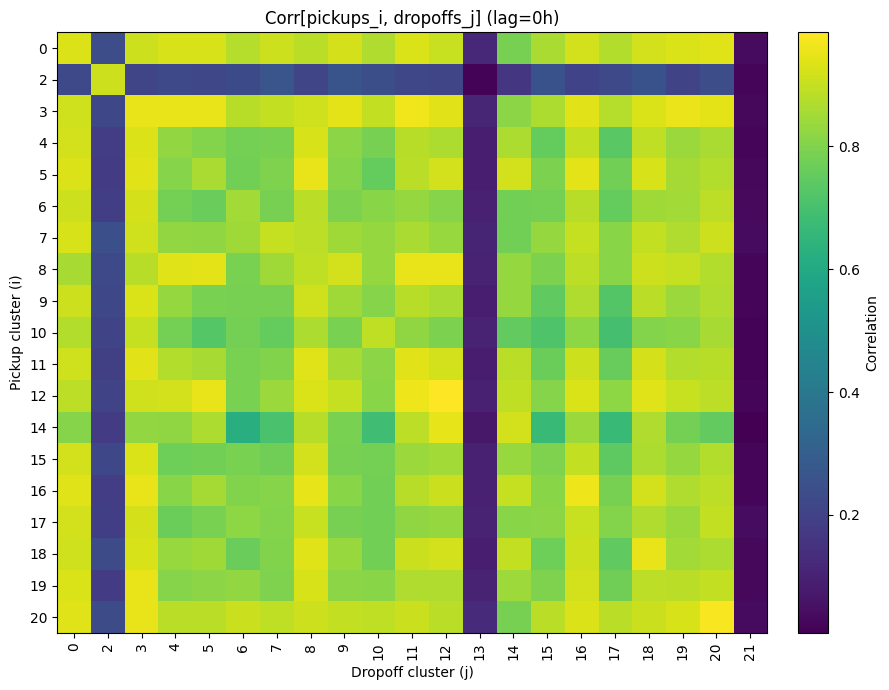

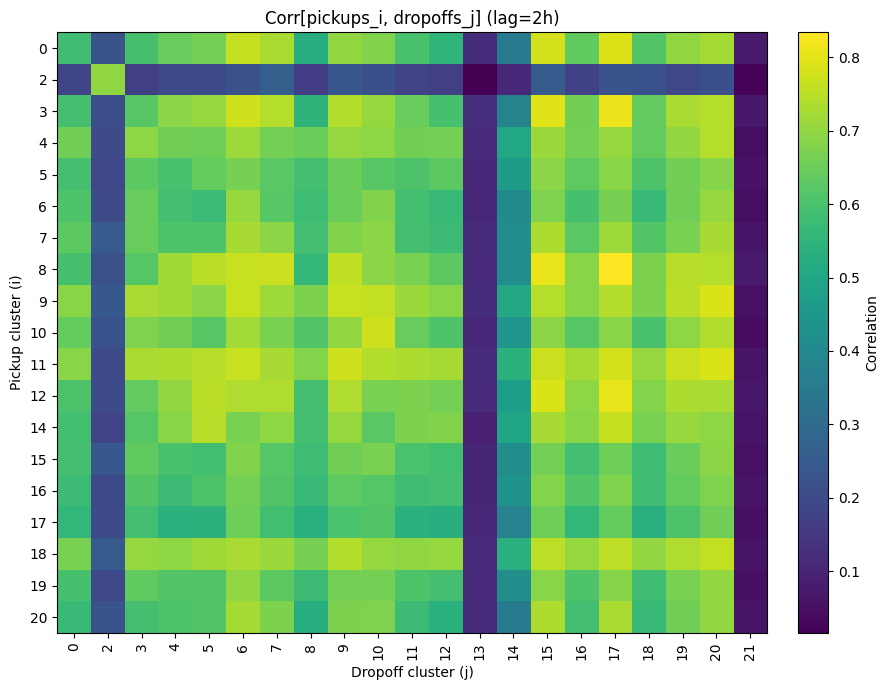

In [128]:
# === Pickup (cluster i) vs Dropoff (cluster j) correlation ===
# Expects df with index=datetime and columns: ['cluster','pickups','dropoffs','demand']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _build_wide(df: pd.DataFrame, value_col: str) -> pd.DataFrame:
    w = df.pivot_table(index=df.index, columns="cluster", values=value_col, aggfunc="sum", fill_value=0)
    try:
        w = w.reindex(sorted(w.columns, key=lambda x: float(x)), axis=1)
    except Exception:
        pass
    return w

def pickup_dropoff_corr_matrix(df: pd.DataFrame, lag_hours: int = 0, method: str = "pearson") -> pd.DataFrame:
    """
    Correlate pickups at cluster i with dropoffs at cluster j.
    lag_hours>0 means dropoffs occur later; we align pickups(t) with dropoffs(t+lag).
    """
    P = _build_wide(df, "pickups")
    D = _build_wide(df, "dropoffs")

    if lag_hours != 0:
        # align pickups(t) with dropoffs(t+lag)
        D = D.shift(-lag_hours)

    # align time index
    common = P.index.intersection(D.index)
    P, D = P.loc[common], D.loc[common]

    # drop constant columns (std=0) to avoid NaNs-only columns
    P = P.loc[:, P.std(ddof=0) > 0]
    D = D.loc[:, D.std(ddof=0) > 0]

    # compute matrix: rows = pickup clusters, cols = dropoff clusters
    mat = pd.DataFrame(index=P.columns, columns=D.columns, dtype=float)
    for dcol in D.columns:
        mat[dcol] = P.corrwith(D[dcol], axis=0, method=method)
    return mat

def plot_pickup_dropoff_corr_heatmap(corr: pd.DataFrame, title_suffix: str = ""):
    fig = plt.figure(figsize=(9, 7)); ax = plt.gca()
    im = ax.imshow(corr.values, aspect="auto")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correlation")

    xt = [str(int(c)) if isinstance(c,(int,np.integer,float)) and float(c).is_integer() else str(c) for c in corr.columns]
    yt = [str(int(r)) if isinstance(r,(int,np.integer,float)) and float(r).is_integer() else str(r) for r in corr.index]
    ax.set_xticks(range(len(xt))); ax.set_yticks(range(len(yt)))
    ax.set_xticklabels(xt, rotation=90); ax.set_yticklabels(yt)
    ax.set_xlabel("Dropoff cluster (j)"); ax.set_ylabel("Pickup cluster (i)")
    ax.set_title(f"Corr[pickups_i, dropoffs_j] {title_suffix}")
    plt.tight_layout()

# ==== Run (examples) ====
# corr_0h: same-hour correlation
corr_0h = pickup_dropoff_corr_matrix(df_demand, lag_hours=0, method="pearson")
plot_pickup_dropoff_corr_heatmap(corr_0h, title_suffix="(lag=0h)")
plt.show()

# corr_2h: pickups(t) vs dropoffs(t+2h) correlation (helpful if effects are delayed)
corr_2h = pickup_dropoff_corr_matrix(df_demand, lag_hours=2, method="pearson")
plot_pickup_dropoff_corr_heatmap(corr_2h, title_suffix="(lag=2h)")
plt.show()


Fontos, hogy az első, pick-up ot a semmiből fogjuk predictálni, trendek stb mindegyik cluster-hoz. --> model 1
A pick-up és past alapján predictálunk drop-offot. Kérdés, hogy fontos-e, hogy adjunk neki adatot az alapján, hogy honnan hová vitték vagy csak a demand számít. 

---

# FORECAST / FUTURE PREDICTION - TASK 2

In [137]:
df_times_clustered.head()

,start_cluster,end_cluster,start_datetime_hour,stop_datetime_hour
0,14.0,14.0,2018-01-01 13:00:00,2018-01-01 14:00:00
1,14.0,12.0,2018-01-01 15:00:00,2018-01-01 15:00:00
2,14.0,12.0,2018-01-01 15:00:00,2018-01-01 15:00:00
3,14.0,14.0,2018-01-01 15:00:00,2018-01-01 15:00:00
4,14.0,4.0,2018-01-01 18:00:00,2018-01-01 18:00:00


In [ ]:
df_demand.reset_index().head()

,datetime,cluster,pickups,dropoffs,demand
0,2018-01-01,0.0,1,0,1
1,2018-01-01,3.0,2,1,3
2,2018-01-01,4.0,8,4,12
3,2018-01-01,5.0,18,20,38
4,2018-01-01,6.0,3,0,3


In [143]:
# ====================== SETUP (assumes df and od are already in memory) ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---- required df schemas ----
# df: DatetimeIndex; columns: ['cluster','pickups','dropoffs','demand']
# od: columns: ['start_cluster','end_cluster','start_datetime_hour','stop_datetime_hour']

# ---- split windows ----
TRAIN_START = "2018-01-01 00:00:00"
TRAIN_END   = "2018-10-31 23:00:00"
TEST_START  = "2018-11-01 00:00:00"
TEST_END    = "2018-12-31 23:00:00"

# ====================== HELPERS ======================
def ensure_dt_index(df_in: pd.DataFrame, name="datetime") -> pd.DataFrame:
    d = df_in.copy()
    if not isinstance(d.index, pd.DatetimeIndex):
        if name in d.columns:
            d[name] = pd.to_datetime(d[name])
            d = d.set_index(name)
        else:
            raise ValueError("DataFrame must have a DatetimeIndex or a 'datetime' column.")
    return d.sort_index()

def full_hourly_index(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    return pd.date_range(idx.min().floor("h"), idx.max().ceil("h") - pd.Timedelta(seconds=0), freq="h")

def build_wide(df_ts: pd.DataFrame, value_col: str) -> pd.DataFrame:
    w = df_ts.pivot_table(index=df_ts.index, columns="cluster", values=value_col,
                          aggfunc="sum", fill_value=0)
    # unify hourly grid
    hours = full_hourly_index(w.index)
    w = w.reindex(hours, fill_value=0)
    try:
        w = w.reindex(sorted(w.columns, key=lambda x: float(x)), axis=1)
    except Exception:
        pass
    return w

def wape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.sum(np.abs(y_true)) + 1e-12
    return float(np.sum(np.abs(y_true - y_pred)) / denom)

# ====================== 1) PICKUPS FORECAST (per-cluster SARIMAX) ======================
df = ensure_dt_index(df_demand)

# build per-cluster hourly matrices
wide_pickups  = build_wide(df, "pickups")
wide_dropoffs = build_wide(df, "dropoffs")

# choose clusters (exclude noise = -1)
clusters_all = [c for c in wide_pickups.columns if (not pd.isna(c)) and (c != -1)]

def forecast_pickups_sarimax_per_cluster(wide_pu: pd.DataFrame,
                                         clusters=None,
                                         seasonal_periods=24) -> pd.DataFrame:
    """Returns a wide matrix (time x cluster) of predicted pickups for TEST window."""
    if clusters is None:
        clusters = wide_pu.columns.tolist()
    test_hours = pd.date_range(TEST_START, TEST_END, freq="h")
    pu_pred = pd.DataFrame(index=test_hours, columns=clusters, dtype=float)

    # loop clusters
    for cid in clusters:
        print(f"Forecasting pickups for cluster {cid}...")
        s = wide_pu[cid]
        # loop days in test; for each day D, forecast its 24h from history <= D-1 23:00
        days = pd.date_range(TEST_START, TEST_END, freq="D")
        for d in days:
            if d.day == 1 and d.hour == 0:
                print(f"  Forecasting day {d.date()}...")
            cutoff = (d - pd.Timedelta(days=1)).replace(hour=23)
            hist = s.loc[:cutoff]
            # fit SARIMAX
            if len(hist) < seasonal_periods * 3:
                # too short; use seasonal naive
                fc_index = pd.date_range(d, d + pd.Timedelta(hours=23), freq="h")
                pu_pred.loc[fc_index, cid] = s.shift(24).loc[fc_index].fillna(0).values
                continue

            mod = SARIMAX(hist, order=(1,1,1),
                          seasonal_order=(1,1,1, seasonal_periods),
                          enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            fc = res.get_forecast(steps=24).predicted_mean.clip(lower=0.0)
            fc.index = pd.date_range(d, d + pd.Timedelta(hours=23), freq="h")
            pu_pred.loc[fc.index, cid] = fc.values
    return pu_pred.fillna(0.0)

pickups_pred_wide = forecast_pickups_sarimax_per_cluster(wide_pickups, clusters=clusters_all, seasonal_periods=24)

# quick pickups metric (WAPE per cluster)
pickups_true_test = wide_pickups.loc[pickups_pred_wide.index, pickups_pred_wide.columns]
wape_pickups = {cid: wape(pickups_true_test[cid], pickups_pred_wide[cid]) for cid in pickups_pred_wide.columns}
print("Pickups WAPE by cluster (lower is better):")
print(pd.Series(wape_pickups).sort_values())

# ====================== 2) OD KERNEL (Jan–Oct) ======================
def prepare_od(od_raw: pd.DataFrame) -> pd.DataFrame:
    od2 = od_raw.copy()
    od2["start_datetime_hour"] = pd.to_datetime(od2["start_datetime_hour"])
    od2["stop_datetime_hour"]  = pd.to_datetime(od2["stop_datetime_hour"])
    # keep sensible records only
    od2 = od2.dropna(subset=["start_cluster","end_cluster","start_datetime_hour","stop_datetime_hour"])
    # integer hours travel time
    dt_hours = (od2["stop_datetime_hour"] - od2["start_datetime_hour"]).dt.total_seconds() / 3600.0
    od2["tau_h"] = np.floor(np.clip(dt_hours, 0, None)).astype(int)
    return od2

od = prepare_od(df_times_clustered)

def build_od_kernel(od_df: pd.DataFrame,
                    origins: list,
                    destinations: list,
                    max_tau: int = 6,
                    alpha: float = 0.2,
                    min_pair: int = 1) -> dict:
    """
    Returns dict[tau] = W_tau (|origins| x |destinations|), rows aligned with 'origins', cols with 'destinations'.
    W_tau[o,d] ~ P(dropoff at d after tau hours | pickup at o at t)
    """
    # TRAIN window
    od_tr = od_df[(od_df["start_datetime_hour"] >= TRAIN_START) & (od_df["start_datetime_hour"] <= TRAIN_END)].copy()
    od_tr = od_tr[od_tr["tau_h"].between(0, max_tau)]

    # counts table: index=(o, tau), columns=d
    counts = (od_tr
              .groupby(["start_cluster","tau_h","end_cluster"])
              .size()
              .rename("cnt")
              .reset_index())

    # pivot to rows=(o, tau), cols=d
    mat = counts.pivot_table(index=["start_cluster","tau_h"], columns="end_cluster", values="cnt",
                             aggfunc="sum", fill_value=0)

    # ensure full grid (all origins x all taus x all destinations)
    full_index = pd.MultiIndex.from_product([origins, range(0, max_tau+1)], names=["start_cluster","tau_h"])
    mat = mat.reindex(full_index, fill_value=0)
    mat = mat.reindex(columns=destinations, fill_value=0)

    # laplace smoothing + row-normalize
    mat = mat.astype(float) + alpha
    row_sums = mat.sum(axis=1).replace(0, np.nan)
    probs = mat.div(row_sums, axis=0).fillna(0.0)

    # pack by tau as dense matrices aligned to provided origins/destinations order
    K = {}
    for tau in range(0, max_tau+1):
        block = probs.xs(tau, level="tau_h", drop_level=False)
        # rows in 'block' are indexed by (start_cluster, tau_h); extract in 'origins' order
        M = block.droplevel("tau_h").reindex(origins).reindex(columns=destinations).to_numpy()
        K[tau] = M  # shape: (n_origins, n_dest)
    return K

origins = clusters_all
destinations = clusters_all
K = build_od_kernel(od, origins, destinations, max_tau=6, alpha=0.2)

# ====================== 3) CONVOLUTION: pickups_pred -> dropoffs_pred ======================
def convolve_dropoffs(pickups_pred_wide: pd.DataFrame,
                      K: dict,
                      origins: list,
                      destinations: list) -> pd.DataFrame:
    """
    For each hour t:  drop_pred(t, d) = sum_o sum_tau pickups_pred(t - tau, o) * K_tau[o,d]
    Returns wide DataFrame (time x destination cluster).
    """
    idx = pickups_pred_wide.index
    drop_pred = pd.DataFrame(0.0, index=idx, columns=destinations)
    # map origin column order to array positions
    pu_mat_full = pickups_pred_wide.reindex(columns=origins).fillna(0.0)
    for tau, W_tau in K.items():
        shifted = pu_mat_full.shift(tau).fillna(0.0).to_numpy()  # (T x |origins|)
        contrib = shifted @ W_tau                                # (T x |destinations|)
        drop_pred += pd.DataFrame(contrib, index=idx, columns=destinations)
    return drop_pred

dropoffs_pred_wide = convolve_dropoffs(pickups_pred_wide, K, origins, destinations)

# ====================== 4) QUICK EVALUATION & PLOTS ======================
# Align true vs predicted in test window
drop_true_test = wide_dropoffs.loc[dropoffs_pred_wide.index, dropoffs_pred_wide.columns]

wape_drop = {cid: wape(drop_true_test[cid], dropoffs_pred_wide[cid]) for cid in dropoffs_pred_wide.columns}
print("Dropoffs WAPE by cluster (lower is better):")
print(pd.Series(wape_drop).sort_values())

# overall WAPE
print("\nOverall WAPE — pickups:", wape(pickups_true_test.values.ravel(), pickups_pred_wide.values.ravel()))
print("Overall WAPE — dropoffs:", wape(drop_true_test.values.ravel(), dropoffs_pred_wide.values.ravel()))

# Plot one example cluster
example_cid = clusters_all[0]
plt.figure(figsize=(14,4))
plt.plot(pickups_true_test.index, pickups_true_test[example_cid], label="Pickups true", linewidth=1)
plt.plot(pickups_pred_wide.index, pickups_pred_wide[example_cid], label="Pickups pred", linewidth=1)
plt.title(f"Cluster {int(example_cid) if float(example_cid).is_integer() else example_cid} — Pickups (Nov–Dec)")
plt.xlabel("Time"); plt.ylabel("Pickups"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,4))
plt.plot(drop_true_test.index, drop_true_test[example_cid], label="Dropoffs true", linewidth=1)
plt.plot(dropoffs_pred_wide.index, dropoffs_pred_wide[example_cid], label="Dropoffs pred (OD kernel)", linewidth=1)
plt.title(f"Cluster {int(example_cid) if float(example_cid).is_integer() else example_cid} — Dropoffs (Nov–Dec)")
plt.xlabel("Time"); plt.ylabel("Dropoffs"); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) OD fit sanity: aggregate OD totals true vs predicted using kernel over test window
def od_totals_from_kernel(pu_pred_wide, K, origins, destinations):
    # sum over time of contributions per OD using kernel weights * predicted pickups
    od_tot = pd.DataFrame(0.0, index=origins, columns=destinations)
    for tau, W_tau in K.items():
        # total pickups per origin over (test hours shifted by tau)
        s = pu_pred_wide.shift(tau).fillna(0.0).sum(axis=0).reindex(origins).to_numpy()  # (|origins|,)
        od_tot += pd.DataFrame(np.outer(s, np.ones(len(destinations))) * W_tau,
                               index=origins, columns=destinations)
    return od_tot

od_kernel_tot = od_totals_from_kernel(pickups_pred_wide, K, origins, destinations)

# True OD totals in test window
od_test = od[(od["start_datetime_hour"] >= TEST_START) & (od["start_datetime_hour"] <= TEST_END)]
od_true_tot = od_test.groupby(["start_cluster","end_cluster"]).size().unstack(fill_value=0).reindex(index=origins, columns=destinations, fill_value=0)

# Simple heatmaps
plt.figure(figsize=(9,7))
plt.imshow(od_true_tot.values, aspect="auto")
plt.colorbar(fraction=0.046, pad=0.04, label="Trips")
plt.xticks(range(len(destinations)), [int(c) if float(c).is_integer() else c for c in destinations], rotation=90)
plt.yticks(range(len(origins)), [int(c) if float(c).is_integer() else c for c in origins])
plt.xlabel("Dest"); plt.ylabel("Origin"); plt.title("OD totals (true, Nov–Dec)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,7))
plt.imshow(od_kernel_tot.values, aspect="auto")
plt.colorbar(fraction=0.046, pad=0.04, label="Trips (kernel-based)")
plt.xticks(range(len(destinations)), [int(c) if float(c).is_integer() else c for c in destinations], rotation=90)
plt.yticks(range(len(origins)), [int(c) if float(c).is_integer() else c for c in origins])
plt.xlabel("Dest"); plt.ylabel("Origin"); plt.title("OD totals (pred from pickups + kernel)"); plt.tight_layout(); plt.show()


Forecasting pickups for cluster 0.0...
  Forecasting day 2018-11-01...


KeyboardInterrupt: 

---

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, List

# ---- helpers ----
def _seasonal_lag(idx: pd.DatetimeIndex) -> int:
    # assume hourly data → 24h seasonality
    return 24

def _safe_div(a, b):
    return np.where(b==0, np.nan, a / b)

def _sMAPE(y, yhat):
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    return np.nanmean(200.0 * np.abs(y - yhat) / np.clip(np.abs(y) + np.abs(yhat), 1e-12, None))

def _MASE(y, yhat, m=24):
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    denom = np.nanmean(np.abs(y[m:] - y[:-m])) if len(y) > m else np.nan
    num = np.nanmean(np.abs(y - yhat))
    return num / denom if denom and denom > 0 else np.nan

def _directional_accuracy(y, yhat):
    # compares direction of change vs previous timestep
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    if len(y) < 2: return np.nan
    dy, dh = np.sign(y[1:] - y[:-1]), np.sign(yhat[1:] - yhat[:-1])
    return np.mean(dy == dh)

def compute_cluster_metrics(preds: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    preds: columns ['cluster', target, f'{target}_pred'] indexed by datetime (no shuffling)
    returns per-cluster metrics incl. contribution to total abs error (WAPE share)
    """
    assert target in preds.columns and f"{target}_pred" in preds.columns
    rows = []
    m = _seasonal_lag(preds.index)
    total_abs_err_all = np.abs(preds[target] - preds[f"{target}_pred"]).sum()
    total_demand_all  = preds[target].sum()

    for cid, g in preds.groupby("cluster"):
        y   = g[target].values
        yhat= g[f"{target}_pred"].values
        err = y - yhat
        mae = np.mean(np.abs(err))
        rmse= np.sqrt(np.mean(err**2))
        mape= np.nanmean(_safe_div(np.abs(err), np.where(y==0, np.nan, np.abs(y)))) * 100.0
        smape = _sMAPE(y, yhat)
        wape = np.nansum(np.abs(err)) / (np.nansum(np.abs(y)) + 1e-12)
        mase = _MASE(y, yhat, m=m)
        bias = np.mean(err)
        diracc = _directional_accuracy(y, yhat)
        # contribution to total absolute error / to total demand
        abs_err_sum = np.nansum(np.abs(err))
        demand_sum  = np.nansum(y)
        contrib_err = abs_err_sum / (total_abs_err_all + 1e-12)
        contrib_dmd = demand_sum / (total_demand_all + 1e-12)

        rows.append({
            "cluster": cid,
            "target": target,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE_%": mape,
            "sMAPE_%": smape,
            "WAPE": wape,
            "MASE": mase,
            "Bias": bias,
            "Directional_Acc": diracc,
            "AbsErr_sum": abs_err_sum,
            "Demand_sum": demand_sum,
            "Error_contrib_share": contrib_err,   # share of total |error|
            "Demand_contrib_share": contrib_dmd,  # share of total demand
        })
    out = pd.DataFrame(rows).sort_values(["target","Error_contrib_share"], ascending=[True, False]).reset_index(drop=True)
    return out


# preds_all: index=datetime; columns at least ['cluster','pickups','dropoffs','pickups_pred','dropoffs_pred']
metrics_pu = compute_cluster_metrics(preds_all, target="pickups")
metrics_do = compute_cluster_metrics(preds_all, target="dropoffs")
display(metrics_pu.head(10))
display(metrics_do.head(10))

# Visualize "who hurts most": cluster contribution to total absolute error
import matplotlib.pyplot as plt
def plot_error_contrib(metrics_df, title):
    m = metrics_df.sort_values("Error_contrib_share", ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(m["cluster"].astype(str), m["Error_contrib_share"])
    plt.ylabel("Share of total |error|"); plt.xlabel("Cluster")
    plt.title(title); plt.tight_layout(); plt.show()

plot_error_contrib(metrics_pu, "Pickups — cluster error contribution")
plot_error_contrib(metrics_do, "Dropoffs — cluster error contribution")


In [ ]:


# --- helpers ---------------------------------------------------------------

def _wide(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Make wide time x cluster matrix for a given series (e.g., 'demand' or 'pickups')."""
    w = (
        df.groupby([df.index, "cluster"])[col]
          .sum()
          .unstack("cluster", fill_value=0)
          .sort_index()
    )
    try:
        w = w.reindex(sorted(w.columns), axis=1)  # numeric sort if possible
    except Exception:
        pass
    return w

def _plot_all_clusters(wide_df: pd.DataFrame, label_prefix: str, lw=1):
    for c in wide_df.columns:
        plt.plot(wide_df.index, wide_df[c], linewidth=lw, label=f"{label_prefix} {int(c)}")

def _plot_overall_mean(wide_df: pd.DataFrame, label="Mean of all clusters", lw=2.5):
    overall = wide_df.mean(axis=1)
    plt.plot(overall.index, overall.values, linewidth=lw, label=label)

def _plot_highlights(wide_df: pd.DataFrame, highlight_clusters=None, label_prefix="Center of Cluster", lw=2.5):
    if highlight_clusters:
        for cid in highlight_clusters:
            if cid in wide_df.columns:
                plt.plot(wide_df.index, wide_df[cid], linewidth=lw, label=f"{label_prefix} {int(cid)}")

# --- 1) Demand over time per cluster --------------------------------------

def plot_demand_over_time_per_cluster(agg, highlight_clusters=None):
    agg = _ensure_demand(agg)
    w = _wide(agg, "demand")

    plt.figure(figsize=(14, 6))
    _plot_all_clusters(w, "cluster", lw=0.8)     # all clusters thin
    _plot_overall_mean(w, "Mean of all data points", lw=2.8)
    _plot_highlights(w, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.xlabel("Time")
    plt.ylabel("Demand (pickups + dropoffs)")
    plt.title("Demand over time per cluster")
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# Example:
# plot_demand_over_time_per_cluster(agg, highlight_clusters=[1,2])

# --- 2) Hourly mean pickups (all clusters + overall mean + highlights) ----

def plot_hourly_mean_pickups(agg, highlight_clusters=None, title_suffix="(All Clusters)"):
    w = _wide(agg, "pickups")
    hourly = w.groupby(w.index.hour).mean()          # per-hour mean per cluster (columns)

    plt.figure(figsize=(12, 4))
    _plot_all_clusters(hourly, "cluster", lw=1.0)
    _plot_overall_mean(hourly, "Mean of all data points", lw=2.8)
    _plot_highlights(hourly, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.title(f"Hourly Mean Pickups {title_suffix}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Pickups")
    plt.tight_layout()
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.show()

# --- 3) Weekday mean pickups (0=Mon … 6=Sun) ------------------------------

def plot_weekday_mean_pickups(agg, highlight_clusters=None, title_suffix="(All Clusters)"):
    w = _wide(agg, "pickups")
    wd = w.groupby(w.index.dayofweek).mean()

    plt.figure(figsize=(12, 4))
    _plot_all_clusters(wd, "cluster", lw=1.0)
    _plot_overall_mean(wd, "Mean of all data points", lw=2.8)
    _plot_highlights(wd, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.title(f"Weekday Mean Pickups {title_suffix}")
    plt.xlabel("Day of Week (0=Mon)")
    plt.ylabel("Pickups")
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# --- 4) Rolling mean pickups (168h weekly window) -------------------------

def plot_rolling_pickups(agg, window=168, highlight_clusters=None, title_suffix="(All Clusters)"):
    w = _wide(agg, "pickups")
    w_roll = w.rolling(window, min_periods=1).mean()

    plt.figure(figsize=(14, 5))
    _plot_all_clusters(w_roll, "cluster", lw=0.9)
    _plot_overall_mean(w_roll, "Mean of all data points", lw=2.8)
    _plot_highlights(w_roll, highlight_clusters, "Center point of Cluster", lw=3.2)

    plt.title(f"Rolling Mean ({window}h) — Pickups {title_suffix}")
    plt.xlabel("Time")
    plt.ylabel("Pickups")
    plt.legend(loc="upper left", ncol=2, fontsize="small")
    plt.tight_layout()
    plt.show()

# --- Run them (example) ---------------------------------------------------
plot_demand_over_time_per_cluster(agg, highlight_clusters=None)
plot_hourly_mean_pickups(agg, highlight_clusters=None)
plot_weekday_mean_pickups(agg, highlight_clusters=None)
plot_rolling_pickups(agg, window=168, highlight_clusters=None)


In [ ]:
# pivot to wide format: index = time, columns = cluster, values = demand
df_wide = agg.reset_index().pivot(index='datetime', columns='cluster', values='demand').fillna(0)
df_wide = df_wide.reindex(sorted(df_wide.columns), axis=1)

plt.figure(figsize=(14, 6))
cmap = plt.cm.tab20
colors = [cmap(i % 20) for i in range(len(df_wide.columns))]

for i, col in enumerate(df_wide.columns):
    label = f"cluster {int(col)}" if not pd.isna(col) else "cluster NaN"
    plt.plot(df_wide.index, df_wide[col], color=colors[i], linewidth=1, label=label)

plt.xlabel('Time')
plt.ylabel('Demand (pickups + dropoffs)')
plt.title('Demand over time per cluster')
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

df_wide.head()



In [ ]:
#NOT CORRECT, MUST BE FIXED


# define cutoff between trainset and testset
trainset_end = pd.to_datetime('2015-05-31 01:00:00')
validationset_start = pd.to_datetime('2015-06-01 01:00:00')
validationset_end = pd.to_datetime('2015-07-31 01:00:00')
testset_start = pd.to_datetime('2015-08-01 01:00:00')

# train/val/test split
X_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, features_to_use]
y_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, target_variables]
X_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), features_to_use]
y_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), target_variables]
X_test = labeled_features.loc[labeled_features['datetime'] > testset_start, features_to_use]
y_test = labeled_features.loc[labeled_features['datetime'] > testset_start, target_variables]

print("Num train examples:", len(y_train))
print("Num validation examples:", len(y_val))
print("Num test examples:", len(y_test))

In [ ]:
# ========= 0) Imports & config =========


# Optional XGBoost; if not installed, keep model_kind='sarima'
try:
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False


# ---- paths / switches ----
CSV_PATH = "/mnt/data/aggregated_demand_data.csv"   # set if you want to load from CSV
MODEL_KIND = "xgb"  # 'sarima' or 'xgb'
CLUSTERS_TO_RUN = None  # e.g. [1,2]; None -> run all clusters in data

# Train/Test windows (per project spec)
TRAIN_START = "2018-01-01 00:00:00"
TRAIN_END   = "2018-10-31 23:00:00"
TEST_START  = "2018-11-01 00:00:00"
TEST_END    = "2018-12-31 23:00:00"

# ========= 1) Load aggregated data (if not already in memory) =========
if "agg" not in globals():
    agg = pd.read_csv(CSV_PATH)

# Ensure datetime index
if not isinstance(agg.index, pd.DatetimeIndex):
    agg["datetime"] = pd.to_datetime(agg["datetime"])
    agg = agg.sort_values(["datetime", "cluster"]).set_index("datetime")

# Ensure 'demand' exists (useful for plotting/QA)
if "demand" not in agg.columns:
    agg["demand"] = agg[["pickups", "dropoffs"]].sum(axis=1)

# ========= 2) Utilities =========
def full_hour_range(df: pd.DataFrame) -> pd.DatetimeIndex:
    return pd.date_range(df.index.min().floor("H"), df.index.max().ceil("H") - pd.Timedelta(hours=0), freq="h")

def make_cluster_ts(agg: pd.DataFrame, cid: int) -> pd.DataFrame:
    """Return hourly time series for one cluster with columns ['pickups','dropoffs'] over a complete hourly index."""
    sub = agg.loc[agg["cluster"] == cid, ["pickups", "dropoffs"]]
    # aggregate to guard against duplicates
    ts = sub.groupby(sub.index)[["pickups", "dropoffs"]].sum().sort_index()
    hours = full_hour_range(ts)
    ts = ts.reindex(hours, fill_value=0)
    ts.index.name = "datetime"
    return ts

def split_train_test(ts: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = ts.loc[TRAIN_START:TRAIN_END]
    test  = ts.loc[TEST_START:TEST_END]
    return train, test

def rmse(y_true, y_pred):
    return float(np.sqrt(((np.asarray(y_true) - np.asarray(y_pred)) ** 2).mean()))

import numpy as np
import pandas as pd

# Reproducible RNG (change seed if you want a different draw)
rng = np.random.default_rng(42)

# Unique, eligible cluster IDs (exclude noise = -1)
eligible = pd.Series(agg["cluster"].dropna().unique())
eligible = eligible[eligible != -1]

# If your clusters are floats (e.g., 1.0), make them ints for readability
try:
    eligible = eligible.astype(int)
except Exception:
    pass

# Pick 5 distinct clusters at random
if len(eligible) < 5:
    raise ValueError(f"Not enough eligible clusters to sample 5 (found {len(eligible)}).")

CLUSTERS_TO_RUN = rng.choice(eligible.to_numpy(), size=5, replace=False).tolist()
print("Selected clusters for prediction:", CLUSTERS_TO_RUN)


# ========= 3) SARIMAX fitting & daily 24-step forecast =========
def fit_sarima(y: pd.Series, seasonal_periods: int = 24):
    """
    Quick SARIMAX fit with a reasonable default order; adjust if you’ve done model selection.
    """
    # Default order: (1,1,1) with simple seasonality; you can grid-search if you want.
    mod = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1, seasonal_periods),
                  enforce_stationarity=False, enforce_invertibility=False)
    return mod.fit(disp=False)

def forecast_next_day_sarima(ts: pd.DataFrame, day: pd.Timestamp) -> pd.DataFrame:
    """
    Given history up to the end of 'day' (23:00), forecast pickups & dropoffs for next 24 hours (day+1, 00:00..23:00).
    Returns DataFrame with index = next-day hours and columns ['pickups_pred','dropoffs_pred'].
    """
    cutoff = day.replace(hour=23, minute=0, second=0)
    hist = ts.loc[:cutoff]
    next_hours = pd.date_range(day + pd.Timedelta(days=1), periods=24, freq="h")

    preds = {}
    for tgt in ["pickups", "dropoffs"]:
        fit = fit_sarima(hist[tgt])
        fc  = fit.get_forecast(steps=24).predicted_mean
        preds[tgt] = pd.Series(np.maximum(0, fc.values), index=next_hours)

    out = pd.DataFrame({"pickups_pred": preds["pickups"], "dropoffs_pred": preds["dropoffs"]}, index=next_hours)
    return out

# ========= 4) XGBoost features & daily 24-step forecast (recursive) =========
def make_features(ts: pd.DataFrame) -> pd.DataFrame:
    d = ts.copy()
    d["hour"]  = d.index.hour
    d["dow"]   = d.index.dayofweek
    d["month"] = d.index.month
    # lags & rolling means
    for col in ["pickups", "dropoffs"]:
        d[f"{col}_lag1"]   = d[col].shift(1)
        d[f"{col}_lag24"]  = d[col].shift(24)
        d[f"{col}_lag168"] = d[col].shift(168)
        d[f"{col}_rmean24"]  = d[col].rolling(24).mean()
        d[f"{col}_rmean168"] = d[col].rolling(168).mean()
    return d

XGB_FEATURES = [
    "hour","dow","month",
    "pickups_lag1","pickups_lag24","pickups_lag168","pickups_rmean24","pickups_rmean168",
    "dropoffs_lag1","dropoffs_lag24","dropoffs_lag168","dropoffs_rmean24","dropoffs_rmean168"
]

def train_xgb_models(train_feats: pd.DataFrame) -> Dict[str, xgb.XGBRegressor]:
    models = {}
    for tgt in ["pickups", "dropoffs"]:
        y = train_feats[tgt]
        X = train_feats[XGB_FEATURES]
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X, y)
        models[tgt] = model
    return models

def forecast_next_day_xgb(ts: pd.DataFrame, models: Dict[str, xgb.XGBRegressor], day: pd.Timestamp) -> pd.DataFrame:
    """
    Recursive 24-step forecast for day+1 using lag/rolling features built from known history + prior predictions.
    """
    cutoff = day.replace(hour=23, minute=0, second=0)
    hist = ts.loc[:cutoff].copy()

    preds_hours = pd.date_range(day + pd.Timedelta(days=1), periods=24, freq="h")
    preds = {"pickups": [], "dropoffs": []}

    cur = hist.copy()
    for h in preds_hours:
        # build features row from current 'cur'
        feats = make_features(cur).iloc[[-1]]  # last available row after updating features
        X_row = feats[XGB_FEATURES]

        # robust scalar extraction (avoids NumPy 1.25 deprecation)
        y_pu_arr = models["pickups"].predict(X_row)
        y_do_arr = models["dropoffs"].predict(X_row)

        # Each is a length-1 array; take the scalar explicitly
        y_pu = float(np.ravel(y_pu_arr)[0])
        y_do = float(np.ravel(y_do_arr)[0])

        preds["pickups"].append(y_pu)
        preds["dropoffs"].append(y_do)

        # append this predicted hour as new "observed" to drive next step
        cur.loc[h, "pickups"]  = y_pu
        cur.loc[h, "dropoffs"] = y_do

    out = pd.DataFrame({
        "pickups_pred": preds["pickups"],
        "dropoffs_pred": preds["dropoffs"]
    }, index=preds_hours)
    return out

# ========= 5) Driver: run per cluster across test days =========
def run_forecasting_for_cluster(agg: pd.DataFrame, cid: int, model_kind: str = MODEL_KIND) -> pd.DataFrame:
    ts = make_cluster_ts(agg, cid)
    train, test = split_train_test(ts)

    # Pre-train (SARIMA re-fits each day from history; XGB trains once on Jan–Oct)
    xgb_models = None
    if model_kind == "xgb":
        if not XGB_AVAILABLE:
            raise RuntimeError("XGBoost not available; set MODEL_KIND='sarima' or install xgboost.")
        train_feats = make_features(train).dropna()
        xgb_models = train_xgb_models(train_feats)

    # loop daily across test window, do 24-step forecast from end of each previous day
    days = pd.date_range(TEST_START, TEST_END, freq="D")
    all_forecasts = []
    for d in days:
        prev_day = d - pd.Timedelta(days=1)
        if prev_day < pd.to_datetime(TRAIN_START):
            continue  # skip if not enough history

        if model_kind == "sarima":
            fc = forecast_next_day_sarima(ts, prev_day)
        else:
            fc = forecast_next_day_xgb(ts, xgb_models, prev_day)

        # attach actuals for evaluation
        actual = ts.loc[d:d + pd.Timedelta(hours=23), ["pickups", "dropoffs"]].copy()
        df = fc.join(actual, how="left")
        df["cluster"] = cid
        all_forecasts.append(df)

        # (Optional) fold actuals into ts here if you want rolling re-training per day; for SARIMA we used full history each call.

    out = pd.concat(all_forecasts).sort_index()
    return out

# ========= 6) Run for all requested clusters & evaluate =========
if CLUSTERS_TO_RUN is None:
    clusters = sorted(agg["cluster"].unique().tolist())
else:
    clusters = CLUSTERS_TO_RUN

all_preds = []
for cid in clusters:
    print(f"Forecasting cluster {cid} with {MODEL_KIND.upper()} ...")
    preds = run_forecasting_for_cluster(agg, cid, MODEL_KIND)
    all_preds.append(preds.assign(cluster=cid))

preds_all = pd.concat(all_preds).sort_index()

# ========= 7) Metrics (MAE / RMSE) =========
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for cid, g in df.groupby("cluster"):
        for tgt in ["pickups", "dropoffs"]:
            y_true = g[tgt].values
            y_pred = g[f"{tgt}_pred"].values
            rows.append({
                "cluster": cid,
                "target": tgt,
                "MAE": mean_absolute_error(y_true, y_pred),
                "RMSE": rmse(y_true, y_pred),
                "N": len(y_true)
            })
    return pd.DataFrame(rows).sort_values(["target","cluster"])

metrics = compute_metrics(preds_all)
display(metrics)

# ========= 8) Quick visual check for one cluster =========
example_cid = clusters[0]
g = preds_all.loc[preds_all["cluster"] == example_cid]
plt.figure(figsize=(14,5))
plt.plot(g.index, g["pickups"], label="pickups actual", linewidth=1)
plt.plot(g.index, g["pickups_pred"], label="pickups pred", linewidth=1)
plt.title(f"Cluster {example_cid} — Pickups: actual vs predicted ({MODEL_KIND.upper()})")
plt.xlabel("Time"); plt.ylabel("Pickups"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
plt.plot(g.index, g["dropoffs"], label="dropoffs actual", linewidth=1)
plt.plot(g.index, g["dropoffs_pred"], label="dropoffs pred", linewidth=1)
plt.title(f"Cluster {example_cid} — Dropoffs: actual vs predicted ({MODEL_KIND.upper()})")
plt.xlabel("Time"); plt.ylabel("Dropoffs"); plt.legend(); plt.tight_layout(); plt.show()


arima, gradientboostingregressor, linearregressor, mlpregressor

2. You are expected to build a prediction model that, at the end of a day, allows to 
predict what the demand for a cluster of stations will be over the next 24 hours – i.e. 
not the total demand for the next day, but how the time-series of the demand will look 
like for the next day (e.g., given demand data until midnight of day 1, predict the 
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm) 
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the 
departures (pickups). You should use a time aggregation of one hour or less. You 
can choose to use two different models or a single one to predict both. It is up to you 
to determine the most effective way to formulate this problem as a machine learning 
problem. You should not shuffle the data. You should instead use the data from 
January to October (included) to train your model, and the data from November and 
December as a test set. You can use any model you want.

januar - oktober -> train
november - december -> test

Overnight, the bike-sharing company manually repositions its bikes to ensure that 
demand for the next day can be met. You are expected to use the outputs from the 
prediction model above to compute the required number of bicycles to be placed in 
each cluster of stations analyzed in Task 2 at the beginning of the next day. To 
compute this number, you can use the cumulative of the arrivals and departures. The 
goal is to ensure that, over the duration of the next day, there will never be a shortage 
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The 
number of bicycles required can be estimated by extrapolating the maximum 
difference between the number of departures and arrivals. 